# Table of contents
1. [Part 1: Anna](#Anna)
    1. [Introduction and Background](#IB1)
    2. [Methods and Results](#MR1)
        1. [681Project\_SymPy\_Sisk.py](#SymPy)
        2. [681Project\_NumSim\_Sisk.py](#NumSim)
    3. [Discussion and Conclusion](#DC1)
2. [Part 2: Alex](#Alex)
    1. [Introduction and Background](#IB2)
    2. [Methods](#Methods)
    3. [Forward-Backward Sweep of a Basic Optimal Control Problem](#OCFBS)
    4. [Forward-Backward Sweep of the Optimal Control Problem of the SEIR Epidemic Model](#OCSEIR)
    5. [Conclusion](#C2)
3. [References](#Ref)

## Part 1: Anna <a name="Anna"></a>

In [63]:
import sympy as sym
from sympy.solvers.solveset import nonlinsolve
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt

### Introduction and Background<a name="IB1"></a>
This project focuses on using epidemic models to explore various aspects of Python. Even though Alex and I worked together on this project, we focused on different implementations and features of Python. The primary focus of my portion of the project was to explore the Python library, SymPy, through the lens of stability and equilibrium analysis of epidemic models. The second part of the project I worked on looked at modifying the SIR.py code given in class to accommodate simulations where there is a parameter change during a run. Since this project relies on epidemic models and modeling, we will start with a brief overview of mathematical epidemic modeling and the specific models used in this project.

There are many different variants of mathematical epidemic models which all serve the same purpose, to track and predict disease spread in a community. Some of the most common models are the susceptible-infectious-recovered (SIR), susceptible-infectious-susceptible (SIS), susceptible-infected (SI), or susceptible-exposed-infectious (SEI). These models work by dividing a population into classes, where the specific classes depend on the disease you are studying and which model is used. For example, a SIS model divides a population into a susceptible class and an infectious class, while a SEI model divides the population into a susceptible class, exposed class, and infectious class. Even though the exact classes vary between models, all mathematical epidemic models have a susceptible class and an infectious class. The susceptible class, denoted by $S$, is defined to be the group of individuals who are not infected with the disease, but are susceptible to infection and the infectious class, denoted by $I$, are the individuals who are not only infected with the disease, but are capable of transmitting it to others. Another important aspect to these models is movement. The most basic way for movement to occur is through interactions between the classes or with the disease. Thus, when the infectious and susceptible classes come into contact there is the possibility of transmission, so those who contract the disease would move from the susceptible class to the infectious class.

Mathematically, epidemic models are described as a dynamical system, often built by ordinary differential equations (ODEs); although some more complicated models can include partial differential equations (PDEs). For this project we are only looking at ODE models. Once these models are described mathematically many kinds of analysis can be preformed. In the 681Project\_SymPy\_Sisk.py code I use Python to explore equilibrium and stability analysis, along with calculating the basic reproductive number, $\mathscr{R}_0$. Briefly (and simplistically), equilibrium and stability analysis looks at the long term behavior of the system and the basic reproductive number is the number of secondary infections caused by one infectious individual. It also has the condition, if $\mathscr{R}_0>1$ then the disease will persist in the population and if $\mathscr{R}_0<1$, the disease will eventually be eliminated. 

In my portion of the project I look at three different epidemic models. Model 1 in the 681Project\_ SymPy\_Sisk.py code comes from Linda Allen's book, *An Introduction to Mathematical Biology* [[1]](#Allen_1). It is a simple SIS model that does not allow for births and deaths, where $N$ is the total population, $\gamma$ is the recovery rate, and $\beta$ is the contact rate. While Model 1, seen below, is a general model, Allen notes that models of this form are often used to study the spread of sexually transmitted diseases/infections since no immunity is gained after recovery.

\begin{equation}
\begin{split}
    \frac{dS}{dt}&=-\frac{\beta}{N}SI+\gamma I\\
    \frac{dI}{dt}&=\frac{\beta}{N}SI-\gamma I
\end{split}
\end{equation}

Model 2 in the 681Project\_SymPy\_Sisk.py code, seen below, is from Fred Brauer and Carlos Castillo-Chavez's book, *Mathematical Models for Communicable diseases* [[2]](#Brauer_2).
\begin{equation}
\begin{split}
    S'&=\Lambda-\beta SI-\mu S\\
    I'&=\beta SI-\mu I-\alpha I\\
    N'&=\Lambda-\mu N
\end{split}
\end{equation}
This is a general SI model, where $N$ is the total population, $\alpha$ is the rate of departure from the infectious class through recovery, $\beta$ is the per-capita contact rate, $\mu$ is the proportional natural death rate, and $\Lambda$ is the density-dependent birth rate. Unlike Model 1, this model allows for births and death, but no deaths caused by the disease. It also assumes everyone is born susceptible and there is full immunity after recovery. Further, the authors note that since the model is asymptotically autonomous we can consider $N$ to be constant and perform analysis on the follow system instead,
\begin{equation}\label{BCModelRed}
\begin{split}
    S'&=\Lambda-\beta SI-\mu S\\
    I'&=\beta SI-\mu I-\alpha I.\\
\end{split}
\end{equation}
This reduced system is used in the 681Project\_SymPy\_Sisk.py.

The last model I looked at is an SEIR model from Hem Joshi, Suzanne Lenhart, Micheal Li, and Liancheng Wang's paper *Optimal Control Methods Applied to Disease Models* [[3]](#LenhartDM_3). I used this model in the 681Project\_NumSim\_Sisk.py code as a part of the modification the SIR.py code. Model 3,
\begin{equation}
\begin{split}
    S'&=bN-dS-\frac{\beta IS}{N}-vS\\
    E'&=\frac{\beta IS}{N}-(\epsilon+d)E\\
    I'&=\epsilon E-(\gamma+\alpha+d)I\\
    R'&=\gamma I-dR+vS\\
    N'&=(b-d)N-\alpha I
\end{split}
\end{equation}
is designed to study a micro-parasitic infectious diseases, where $\alpha$ is the death rate caused by the disease, $b$ is the natural birth rate, $\beta$ is the adequate contact rate between susceptible and infectious individuals, $d$ is the natural death rate, $\epsilon$ is the rate exposed individuals become infectious, $\gamma$ is the recovery rate, and $v$ is the constant per capita vaccination rate. This model is more complicated then Models 1 and 2 since the disease requires an incubation period in the host before they become infectious (able to transmit the disease to other). This is seen by the inclusion of the exposed class. For my part of the project I am assuming a constant vaccination rate even though the main focus of the paper is to find the optimal vaccination rate using optimal control techniques. Alex will go into the detail of the optimal control problem and implementation in Python in her [section](#Alex) of the project.

Now that we have some background on mathematical epidemic modeling and the particular models we are working with we will go through a brief introduction into the SymPy library. SymPy, short for symbolic Python, is Python's mathematical symbolic library. According to the SymPy website the aim is "to become a full-featured computer algebra system (CAS) while keeping the code as simple as possible in order to be comprehensible and easily extensible"[[7]](#SymPy_7). Since SymPy is is written entirely in Python, once a user has gained familiarity Python's syntax it is relatively easy to learn how to use. This makes it a great alternative to other symbolic mathematical programs like Maple and Mathematica, where the user would need to learn a new syntax before using it. SymPy has a wide range of features and modules ranging from basic algebraic manipulation and simplification of symbolic expressions up to more complicated tasks like solving ODEs/PDEs and computations on symbolic matrices. To get familiar with the basic of SymPy, let's look at some examples. 

We will start with some simple expression manipulation. Note, unlike in other CAS programs (like Maple) the user must first initialize the symbols that will be used.

In [64]:
x = sym.Symbol('x')
y = sym.Symbol('y')

Now that we have initialized the $x$ and $y$ symbols we can use them in a symbolic expression. The command 'pprint', short for pretty print, formats symbolic expressions (which is unnecessary in a Jupyter Notebook environment) and the command 'expand' foils out the expression, as expected.

In [65]:
sym.pprint((x+y)**2)
sym.expand((x+y)**2)

       2
(x + y) 


x**2 + 2*x*y + y**2

Going one step further we can use the 'solve' command to find solutions to symbolic expressions. Note, the 'solve' command is used to find roots and thus only requires the non-zero side of the equation.

In [66]:
sym.solve((x+y)**2,x)

[-y]

Now that we have seen some of the basic functions of SymPy, let's look at look at a more sophisticated feature-solving an ODE. While SymPy can handle ODE and PDE systems, in this example we will look at the differential equation for exponential growth. First, we define the symbolic function, $P(x)$, similar to how we defined other symbols, and then define $r$, the intrinsic growth, as before. Like the the 'solve' command, 'dsolve' requires the differential equation to be set equal to zero. Hence, we rearrange the differential equation as follows,
\begin{equation}
\begin{split}
    P'&=rP\\
    \implies P'-rP&=0
\end{split}
\end{equation}
and pass 'dsolve' the left hand side.

In [67]:
P = sym.symbols('P', cls=sym.Function)
r = sym.Symbol('r')
sym.dsolve(P(x).diff(x)-r*P(x))

Eq(P(x), C1*exp(r*x))

While SymPy is able to solve various different types of ODEs and PDEs, there is a limit to the complexity it can handle. In addition to differential equations, SymPy also has modules dedicated to differential geometry, Lie algebra, category theory, logical and boolean expressions, and tensor operations to name a few. A full list of the modules and features of the SymPy library can be found on it's documentation page [[7]](#SymPy_7). For the 681Project\_SymPy\_Sisk.py code I explore the utility of the symbolic solvers, print formatting, and the ODE and linear algebra modules. Now that we have some background information we can explore the 681Project\_ SymPy\_Sisk.py and 681Project\_NumSim\_Sisk.py codes.

### Methods and Results <a name="MR1"></a>
#### 681Project\_ SymPy\_Sisk.py <a name="SymPy"></a>
We will start with looking at the 681Project\_ SymPy\_Sisk.py code. I decided to use functional programming for this code, so I could look at more then one model. This code has three functions: eq_points, stability, and NextGen. All of these functions were built to preform basic equilibrium and stability analysis that, while usually can be done by hand, is often algebraically tedious.

The first function we will look at is eq_points. As the name suggests this function returns the equilibrium points of a model/system. The arguments for the function are the system itself and a list of the state variables, so the solver knows for which symbols it is solving.

In [68]:
def eq_points(system,state_var):
    eq_pts = list(nonlinsolve(system, state_var))
    return eq_pts

The functions passes its arguments into the SymPy 'nonlinsolve' command and it catches the outputs in a list. The list is then named eq_pts and is passed back to the user. 

The next function is named stability. This function helps a user determine if an equilibrium point is stable/unstable by using traditional linearization techniques. Similar the eq_pts function, the arguments for stability are the system, the state variables, and the equilibrium point of interest. This function uses the linear algebra/matrix module from SymPy.


In [69]:
def stability(system,state_var,eq):
    #Find the jacobian
    X = sym.Matrix(system) 
    Y = sym.Matrix(state_var)   
    jacobian = X.jacobian(Y)

    #Evaluate Jacobian at equilibrium point
    jacobian_eq = jacobian
    for i in range(len(state_var)):
        jacobian_eq = jacobian_eq.subs(state_var[i],eq[i])
    
    #Find the eigenvalues of the jacobian evaluated at equilibrium point
    eigenval = []
    for i in jacobian_eq.eigenvals():
        eigenval.append(i)
    for i in range(len(eigenval)):
        if eigenval[i]==0:
            warning="Stability cannot be determine due to zero eigenvalue!"
            zeoeig=True
            break
        else:
            zeoeig=False
    if zeoeig==True:
        return warning
    else:
        return eigenval

This function starts by putting the equations from the system and the state variables into separate matrices of the same size. Then using SymPy's 'jacobian' function, creates the jacobian matrix by passing the system and state variable matrices. The next step is to evaluate the jacobian at the given equilibrium point. To do this I set up a for-loop to run for the number of state variables and substituted the equilibrium point value into the matrix for each state variable. I then used the 'eigenvals' command to find the eigenvalues of the jacobian evaluated at the equilibrium point, which was put into a list. Since stability can only be determined using linearization when there are non-zero eigenvalues, the last for-loop in the function checks each eigenvalue to see if it is zero. If there is a zero eigenvalue, it will automatically return a warning to the user that stability is unable to be determined using linearization techniques. If there are no zero eigenvalues, then the functions returns the list of the eigenvalues. Since the eigenvalues are purely symbolic the user then must decide if the eigenvalues are positive or negative and thus whether the equilibrium point is stable or unstable.

The last function in this code is NextGen. This function uses the technique of finding the next generation matrix to calculate the basic reproductive number. Setting up the next generation matrix requires dividing your model between the infected classes, which we will call $X$, and the non-infected classes, which we will call $Y$. The infected classes include not only the infectious class, but also any exposed or carrier classes. For this process, transmissiblity is not needed to be considered 'infected'. Using Model 1 as an example, $X = I$ and $Y = S$. Now that the model is divided, the terms in the infected class(es) must be subdivided into terms that signify new infections (in flow rates to $X$ from $Y$), called $f$, and all other rates, called $v$. Thus the infected class(es), can be written as,
\begin{align*}
\frac{dX}{dt}=f-v.
\end{align*}
For Model 1, $f=\frac{\beta}{N}SI$ and $v=-\gamma I$. Next, the derivative (or take the jacobian depending on the dimension) of $f$ and $v$ must be found with respect to the state variable(es) of the infected class(es). Then these jacobians are evaluated at the disease free equilibrium point. We will refer to these modified $f$ and $v$ as $F$ and $V$, respectively. For Model 1, $F = \frac{\beta}{N}S^*$ and $V = -\gamma$. where $S^*$ is the $S$ value of the disease free equilibrium point. With $F$ and $V$, the next generation matrix can be defined as $FV^{-1}$. Now that we have the next generation matrix, we can find it's eigenvalues. The largest one, also called the spectral radius, is the basic reproductive number. So, for Model 1,
\begin{align*}
FV^{-1}&=\frac{\beta}{N}S^*\Big(-\frac{1}{\gamma}\Big)\\
&=-\frac{\beta\gamma S^*}{N}
\end{align*}
Thus, the basic reproductive number for Model 1 is $-\frac{\beta\gamma S^*}{N}$. This explanation was based on slides from B. Song at Montclair State University [[6]](#Song_6).

The Nextgen function follows the exact process outlined above. The arguments it requires are a list of the infected state variables ($X$ from above), the list of all the state variables from the model, the in flow rates ($f$), the other rates ($v$), and the disease free equilibrium point. Since the eigenvalues are purely symbolic, Python cannot determine which is the largest, so it returns all of the eigenvalues of the next generation matrix. The user must decide which is the largest, and hence the basic reproductive number.

In [70]:
def NextGen(InfectVar,state_var,InFlow,OFlow,DFE):
    f=sym.Matrix(InFlow)
    v=sym.Matrix(OFlow)

    F=f.jacobian(InfectVar)
    V=v.jacobian(InfectVar)

    for i in range(len(InfectVar)):
        F=F.subs(state_var[i],DFE[i])

    for i in range(len(InfectVar)):
        V=V.subs(state_var[i],DFE[i])   
    InverseV=sym.Inverse(V)
    NextGen=F*InverseV
    return NextGen.eigenvals()

Now that we are familiar with the functions in the 681Project\_ SymPy\_Sisk.py code we can apply them to Models 1 and 2. First, we will work with Model 1. Below we define the symbols needed for the model and then the model itself. Note, to simplify the code we have let $\beta$ = b and $\gamma$ = g.

In [71]:
#Model 1
#State variables
S = sym.Symbol('S')
I = sym.Symbol('I')
state_var = [S,I]

#Parameters
b = sym.Symbol('b')
g = sym.Symbol('g')
N = sym.Symbol('N')

#Model definition
Sdot = (-b/N)*S*I+g*I
Idot = (b/N)*S*I-g*I
system = [Sdot,Idot]

Now that we have our model defined and have created lists that contain the state variables and the right hand sides of the model, we can call on our functions. 

In [72]:
eq = eq_points(system,state_var)
stabil = stability(system,state_var,eq[0])
basic_repro = NextGen([I],state_var,[(b/N)*S*I],[g*I],eq[0])

#print statements
sym.pprint('The equilibrium points are {}.'.format(eq))
sym.pprint('Stability of the equilibrium: {}.'.format(stabil))
print('The basic reproductive number is' )
for x in basic_repro:
    print('{}.'.format(x))

The equilibrium points are [(S, 0), (N*g/b, I)].
Stability of the equilibrium: Stability cannot be determine due to zero eigenv
alue!.
The basic reproductive number is
S*b/(N*g).


We can repeat the same process with Model 2. Again, we have replaced the Greek letter with Roman letters as follows: $\alpha$ = a, $\beta$ = b, $\mu$ = u, and $\Lambda$ = h. 

In [73]:
# Model 2
#State variables
S = sym.Symbol('S')
I = sym.Symbol('I')
state_var = [S,I]

#Parameters
a = sym.Symbol('a')
b = sym.Symbol('b')
u = sym.Symbol('u')
h = sym.Symbol('h')

#Model definition
Sdot = h-b*S*I-u*S
Idot = b*S*I-u*I-a*I
system = [Sdot, Idot]
  
# calling functions
eq = eq_points(system,state_var)
stabil = stability(system,state_var,eq[0])
basic_repro = NextGen([I],state_var,[b*S*I],[I*(u+a)],eq[0]) 

#print statements
sym.pprint('The equilibrium points are {}.'.format(eq))
sym.pprint('Stability of the equilibrium: {}.'.format(stabil))
print('The basic reproductive number is' )
for x in basic_repro:
    print('{}.'.format(x))

The equilibrium points are [(h/u, 0), (-(-h - (a*u - b*h + u**2)/b)/u, -(a*u -
 b*h + u**2)/(b*(a + u)))].
Stability of the equilibrium: [-u, -a + b*h/u - u].
The basic reproductive number is
b*h/(u*(a + u)).


One can either check by hand or look the source material for the models to see the functions perform as expected.

#### 681Project\_NumSim\_Sisk.py <a name="NumSim"></a>
The second part of the project I worked on is the 681Project\_NumSim\_Sisk.py code. For this code I modified the SIR.py code given in class so it can accommodate parameter changes during a run. Since the framework of the code was given in class here we will be focusing on the modifications. The first change that was made is the model. Instead of using the original SIR, Model 3, introduced above, was used. With the addition of a for-loop the code also runs four simulations, each with a different parameter set, but because of this the code cannot be split up in this notebook. To 
accommodate I have added comments to the code below breaking it up into parts and have labeled the following paragraphs accordingly.

Part 1:

Note, that the parameter values used, with the exception of the vaccination rate, come from [[3]](LenhartDM_3). The $i = 0$ simulation looks at the result of vaccination from the beginning of an outbreak, while The $i = 1$ simulation, shows the result of no vaccination. The last two simulations take into account parameter changes. The third run ($i = 2$) looks at what happens when a community starts with no vaccination, but it is later introduced at time $t = 250$ and the fourth run ($i = 3$) also looks at community that starts with no vaccination, but is later introduced at time $t = 170$. The difference between the third and fourth runs is in the fourth run the vaccination is removed at $t = 340$, but is never removed after introduction in the third.

Part 2:

With the exception of making small modifications to the code to account for the model change, the next piece of code is the same from the SIR.py code. It sets up the model and prepares for solving.

Part 3:

This is the part of the code that allows for the parameter changes. First, parameter switch times are defined for both runs three and four. As noted before, run three has one switch time called, $j$ at $t = 250$ and run four has two switch times called $k$ and $2k$, where $k = 170$. By using both the for-loop, that determines which of the runs is happening ($i = 0 ,1 ,2 ,3$), and multiple if-statements we are able to change the parameters at the switch times for the specific runs. 

The first if-statement records the initial conditions and the second records the solutions up to $k$ (the smaller of the switch times) for all four runs. The third if-statement checks to see if the program is in the third or fourth run. If it is not, the simulation continues to record the solution with the parameters unchanged. The fourth if-statement checks if the program is in the third run, if so it continues to solve and record solutions without changes in the parameter up until $t = j$. If the program is in the fourth run, it will move to the next if-statement and the parameters will be changed to add in vaccination. Then the solutions will be recorded up to $2k$. Again for the fourth run, the sixth if-statement is entered and changes the vaccination rate back to zero and finishes recording the solutions. The last if-statement is entered if the program in the third run and will introduce vaccination and record the rest of the solutions. Although in this code only one parameter is changing, one can easily change as many parameters as need in these if-statements. 

Part 4:

Now that all of the solutions have been recorded, the last part of the code prints the plots for each run. Note that susceptible individuals who receive a vaccine are moved from the susceptible class to the recovered class. That is why immediately after vaccination is introduced the population in the susceptible class lowers before increasing and vice versa when vaccination is removed.

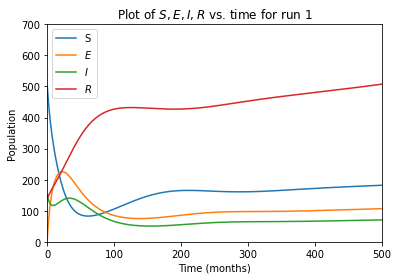

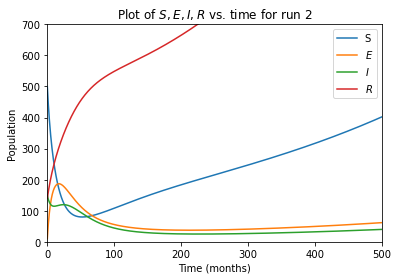

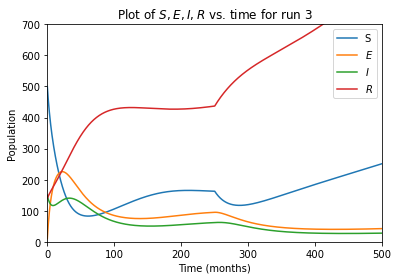

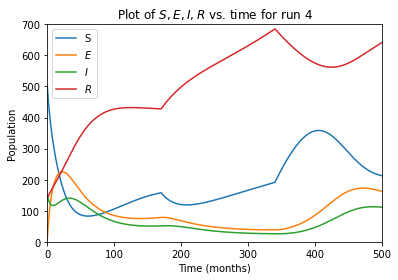

In [74]:
#time points to solve at
final_time = 500
tpts = np.linspace(0, final_time,1001)

#initial values as for each class
S0 = 500
E0 = 10
I0 = 150
R0 = 140
N0 = S0+E0+I0+R0

#Part 1
#parameter values stored in a dictionary
params = {}
for i in range(0,4):
    if i==0: #No vaccine
       params['a'] = .03
       params['b'] = .008
       params['c'] = .4
       params['d'] = .005
       params['e'] = .05
       params['g'] = .04
       params['v'] = 0 
    if i==1: #Vaccination from the beginning
       params['a'] = .03
       params['b'] = .008
       params['c'] = .4
       params['d'] = .005
       params['e'] = .05
       params['g'] = .04
       params['v'] = .02
    if i==2: #Vaccination introduced later
       params['a'] = .03
       params['b'] = .008
       params['c'] = .4
       params['d'] = .005
       params['e'] = .05
       params['g'] = .04
       params['v'] = 0 
    if i==3: #Vaccination introduced later and then removed
       params['a'] = .03
       params['b'] = .008
       params['c'] = .4
       params['d'] = .005
       params['e'] = .05
       params['g'] = .04
       params['v'] = 0 

    ##################################
#Part 1 end

#Part 2
    #vectorize initial conditions
    x0 = np.array([S0,E0,I0,R0,N0])
        # define ode equations
    def SEI_ODEs(t,x,params):
        '''This function returns the time derivates of S,E,I,R,N.

        The ode solver expects the first two arguments to be t and x
        NOTE: This is the OPPPOSITE order from scipy.integrate.odeint!!

        The params argument should be a dict with a,b,c,d,e,g, and v as keys.
        It must be passed into the solver using the set_f_params method
        '''

        S = x[0]; E = x[1]; I = x[2]; R = x[3]; N = x[4]
        dx = np.zeros(5)

        dx[0] = params['b']*N-params['d']*S-(params['c']*S*I)/N-params['v']*S
        dx[1] = (params['c']*S*I)/N-params['e']*E-params['d']*E
        dx[2] = params['e']*E-params['g']*I-params['a']*I-params['d']*I
        dx[3] = params['g']*I-params['d']*R+params['v']*S
        dx[4] = params['b']*N-params['d']*N-params['a']*I

        return dx

    ###########################
    ##### Solve procedure #####
    ###########################
    Ssol = []; Esol = []; Isol = []; Rsol = []; Nsol = []

    # create solver object
    solver = ode(SEI_ODEs)
        # set the solver method to RK 4(5), Dormand/Prince
        # see the docs for scipy.integrate.ode for the options with this solver
        # here we'll use the defaults, but pay attention to atol/rtol especially
    solver.set_integrator('dopri5')
        # set the initial conditions
    solver.set_initial_value(x0,0)
        # pass in the solver parameters
    solver.set_f_params(params)
#Part 2 end

#Part 3
        # the solver will solve (integrate) up to a given time.
        # we want a mesh of times, so we will integrate up to each time in our
        # mesh in a loop
    for t in tpts:
        k = 170 #switch time for parameters during the fourth run
        j = 250 #switch time for parameters during the third run

        if t == 0: #records the initial conditions
            Ssol.append(x0[0])
            Esol.append(x0[1])
            Isol.append(x0[2])
            Rsol.append(x0[3])
            Nsol.append(x0[4])

        if 0<t<=k: #integrates up to the smaller switch time and records solution
            solver.integrate(t)
            assert solver.successful(), "Solver did not converge at time {}.".format(t)
            Ssol.append(solver.y[0])
            Esol.append(solver.y[1])
            Isol.append(solver.y[2])
            Rsol.append(solver.y[3])
            Nsol.append(solver.y[4])

        if t>k and i!=2 and i!=3: #if we aren't in the third or fourth run then, the simulation continues unchanged
            solver.integrate(t)
            assert solver.successful(), "Solver did not converge at time {}.".format(t)
            Ssol.append(solver.y[0])
            Esol.append(solver.y[1])
            Isol.append(solver.y[2])
            Rsol.append(solver.y[3])
            Nsol.append(solver.y[4])
        
        if k<t<=j and i==2: 
        #for the third run it continues to integrate up to its switch time without parameter changes and records solution
            solver.integrate(t)
            assert solver.successful(), "Solver did not converge at time {}.".format(t)
            Ssol.append(solver.y[0])
            Esol.append(solver.y[1])
            Isol.append(solver.y[2])
            Rsol.append(solver.y[3])
            Nsol.append(solver.y[4])

        if k<t<=2*k and i==3 and i!=2:
        #for the fourth run once we hit its switch time (k) the parameters change (for the first time), 
        #then the solution is recorded with the new parameters
            params['v'] = .02

            solver.integrate(t)
            assert solver.successful(), "Solver did not converge at time {}.".format(t)
            Ssol.append(solver.y[0])
            Esol.append(solver.y[1])
            Isol.append(solver.y[2])
            Rsol.append(solver.y[3])
            Nsol.append(solver.y[4])

        if t>2*k and i==3: #Second parameter change for the fourth run
            params['v'] = 0

            solver.integrate(t)
            assert solver.successful(), "Solver did not converge at time {}.".format(t)
            Ssol.append(solver.y[0])
            Esol.append(solver.y[1])
            Isol.append(solver.y[2])
            Rsol.append(solver.y[3])
            Nsol.append(solver.y[4])
        
        if t>j and i==2: 
        #for the third run once we hit its switch time (j) the parameters change, 
        #then the solution is recorded with the new parameters
            params['v'] = .02

            solver.integrate(t)
            assert solver.successful(), "Solver did not converge at time {}.".format(t)
            Ssol.append(solver.y[0])
            Esol.append(solver.y[1])
            Isol.append(solver.y[2])
            Rsol.append(solver.y[3])
            Nsol.append(solver.y[4])

#Part 4
#######################
##### Plot result ######
########################
    plt.figure()
    plt.title("Plot of $S,E,I,R$ vs. time for run {}".format(i+1))
    plt.plot(tpts, Ssol,tpts, Esol,tpts, Isol, tpts, Rsol)
    plt.legend(['S','$E$','$I$','$R$'])
    plt.xlabel("Time (months)")
    plt.ylabel("Population")
    plt.ylim(0,700)
    plt.xlim(0,final_time)

plt.show()
#Part 4 end

The first two plots show the behavior of the community in the abscence and presence of a vaccine, respectively. As expected, the first has a higher infectious and exposed population as time goes on. The third and fourth plots explore the effects of a non-constant vaccination regime. In most cases this will be more realistic as vaccinations efforts rely on many contingency, such as vaccine availability, distribution logistics, public trust, and medical personnel to name a few. The third plot, is an example of where a vaccine is not available at the beginning of an outbreak, but is later on. An obvious real world example of this is the COVID-19 pandemic. The fourth plot, looks at a similar situation as the third, but here the vaccination effort eventually ends. This could be due to distribution issues, inadequate supply, or discontinuation of funding. While it is useful to see the outcome of a parameter changing during a run, the current implementation is not completely realistic. In this code the changes happen automatically, whereas in real life these types of changes would be likely be gradual. It is because of these abrupt changes we see cusps appear in the plots. Therefore the third and fourth plots are more useful for overall trends, then the specific details.

### Discussion and Conclusion<a name="DC1"></a>
Before this class, my entire coding experience was limited to a one semester introduction to Java course as an undergrad and what I taught myself in MATLAB and Maple. Needless to say, I learned a lot during this course and project. My motivation for this project was to learn skills in Python I can directly apply to my dissertation work. Part of my research is on an SEI model that I built and one of the first things I worked on was equilibrium and stability analysis. Due to the dimension of the model I couldn't do that work by hand, so I had to learn how use a symbolic math program. Since I worked on this before taking this class I taught myself how to use Maple. On this same model, I also needed to run some basic numerical simulations where there was a parameter change during the run corresponding to different events in the environment. I was running my simulations in MATALB, but struggled to incorporate this feature into the code. Since both of these situation are relatively common when working on a mathematical biology project, especially any topic dealing population level dynamics, I chose to explore these in this project. Since most of my classmates are also working in mathematical biology I think learning these skills in a programming language they are now familiar with is useful. Specifically for preforming symbolic calculations, knowing how to utilize SymPy eliminates the need to download and learn a new CAS program, which saves the time and frustration of learning a new syntax.

When I started the 681Project\_SymPy\_Sisk.py code I wasn't sure which coding paradigm I wanted to use, so I started with a script and used 'brute force' to get my ideas into code. Once I got the script running, I realized I wanted the ability to analyze multiple models. In the original format I would essentially have to copy and paste all of the code for each model. That's when I decided to convert my 'brute force' script into a functional program. Functional programming was something I had relatively little experience, as in my Java class we spent more time learning object oriented programming, so I wanted to use this project to get familiar with it. The most challenging apart about using functional programming was having to write the code for a general case. It took some trial and error to make sure the functions could run for both models in the code and not customize to work only for one.

Since the 681Project\_NumSim\_Sisk.py code was just modified from the SIR.py code given in class, I only had to focus on how to implement the parameter change. The most straight forward way to accomplish this was using if-statements. I first wrote this code to only include one parameter change, which was relatively simple. In fact, earlier in the semester I was able to implement this in code for my dissertation work. So, for this project I wanted to take it a step further by having a run where there was two parameter changes. I was surprised by how much more difficult it was to organize three different $t$ values where it was possible for a parameter change. Another challenge was ensuring only the correct runs would enter an if-statement block at the correct time. I was able to work through this using some of the debugging techniques discussed in class. Specifically, placing print statements in if-statement blocks to determine when the code was entering it.

This project was the first time I've collaborated on a coding project. Even though Alex and I didn't co-write our Python code, we did contribute to a Git Hub repository and worked in the same Jupyter Notebook. Before this class I had no experience with either of these tools. There was definitely a learning curve getting the Git Hub and Jupyter Notebook set up and started, but once we figured them out they were really useful tools that made collaborating much easier. For example, without them we would have either emailed all the files back and forth or set up a google drive/drop box to use. While these options can be useful, they aren't ideal for working on files together. Even though the Jupyter Notebook ended up working well for us, we definitely has some initial struggles. First off, Alex and I had a fundamental misunderstanding on how Jypter Notebooks worked. We thought it was similar to how OverLeaf works. We quickly found out this wasn't the case when we had a merge conflict. Unfortunately, this happened before it was addressed in lecture so we deleted that notebook and started again. Although frustrating at the time, that experience did give us a better understanding of how local versions of a file and the files in Git Hub interact. Working with a partner also enabled me to learn about the Python tools she was exploring that otherwise I would not have seen. Further, project partners are great debugging 'rubber ducks'. Without having someone to talk to debugging would taken much more time and caused additional frustration and stress. Overall, working on this project with a partner was not only was helpful, but also provided experience working on a collaborative coding project that will be useful in the future. To conclude, this project, and class in general, has taught me a lot and I feel more confident in my coding abilities. In fact, I am already implementing what I have learned into my own research.

## Part 2: Alex <a name="Alex"></a>

### Introduction and Background<a name="IB2"></a>
This project centers on the micro-parasitic infectious disease. This epidemic model has been examined in various ways using python. Anna and I have taken this model and used different aspects of python to explore a new library and a new technique. For my portion of the project, I focused on solving two optimal control problems using the Forward-Backward Sweep. The first problem is a simple optimal control problem subject to an ordinary differential equation. The second is an optimal control problem subject to the micro-parasitic infectious disease epidemic model. I will not go into much detail about epidemic models, since Anna has already gone through some background in Part1. I will instead start with a short but sweet overview of optimal control theory and the Forward-Backward Sweep.

The micro-parasitic infectious disease taken from the paper "Optimal Control Methods Applied to Disease Models‚Äù is an epidemic where everyone is born susceptible and permanent immunity from the disease can be achieved through natural recovery or immunization. To model this epidemic we will use the following SEIR (or SEIRN) model[[3]](#LenhartDM_3):
\begin{align*}
& S' = bN - dS - \frac{\beta IS}{N} - uS\\
& E' = \frac{\beta IS}{N} - (\epsilon +d)E\\
& I' = \epsilon E - (\gamma +\alpha +d)I\\
& R' = \gamma I - dR + uS\\
& N' = (b-d)N - \alpha I
\end{align*}

For simplicity, the Greek letters were replaced with letters from the English alphabet. Also, note that since $\frac{\beta}{N}$ is a constant, it is replaced by c. Therefore, we see that[[4]](#LenhartBM_4):
\begin{align*}
& S' = bN - dS -cSI - uS\\
& E' = cSI - (e+d)E\\
& I' = eE - (g+a+d)I\\
& R' = gI - dR + uS\\
& N' = (b-d)N - aI
\end{align*}


In epidemic models [[1]](#Allen_1) [[4]](#LenhartBM_4), $S$, $E$, $I$, $R$, and $N$ are defined as follows. $S$ is defined as the susceptible individuals. These are individuals who are not yet infected but could be. $E$ is defined as the exposed individuals. These are individuals who were exposed to the disease. $I$ is defined as the infected individuals. These are individuals who are infectious. $R$ is defined as the recovered individual. These are the individuals who were able to recover from the disease. $N$ is the total number of people in the population. Thus, $N = S+E+I+R$.

In our SEIR model, the natural birth rate is $b$ and the natural death rate is $d$. The term $cSI$ represents the number of infections caused by the infected. The rate at which exposed individuals become infected is $e$. So, $\frac{1}{e}$ is the mean latent or exposed period. The rate at which infected individuals recover is $g$. Thus, $\frac{1}{g}$ is the mean infectious period. Lastly, $a$ is the death rate caused by the disease [[3]](#LenhartDM_3)[[4]](#LenhartBM_4). We will use an optimal control technique to find the vaccination schedule of susceptible individual per unit of time for the micro-parasitic infectious disease. However, before we go any further we need a little overview of optimal control theory.





<img src="MA681_SEIR_Model.png" alt="SEIR Model" width="600"/>

<b>Figure 1: </b> This is a flow chart of our SEIR model. The boxes represent the four types of individuals. The arrows show the movement between boxes.



### Methods  <a name="Methods"></a>
#### Optimal Control 
The mathematical theory behind adjusting controls in a system to achieve a goal is called optimal control. It is used to make decisions involving complex biological situations. The SEIR model is a system of Ordinary Differential Equations. A few things to note about the control of Ordinary Differential Equations: $u(t)$ represents the control which is used to steer the state, the state  is $x(t)$ which describes the behavior of the underlying dynamical system. In short, the state function satisfies the differential equation while the control affects the DE. $x'(t)$ is our DE, $u(t)^*$ is the optimal control, $x(t)^*$ is the optimal state, and $u(t)^*, x(t)^*$, our optimal pair,  will help us reach our goal, the objective functional. Note that the optimal control $u^\ast(t)$ achieves the maximum. We put $u^\ast(t)$ into the state DE to obtain $x^\ast(t)$.[[4]](#LenhartBM_4).

Formulating an optimal control consist of finding the piece-wise continuous control $u(t)$ and associated state variable $x(t)$ to maximize the objective function which is subject to a DE where $x(0)=x_0$, $x(T))$ is free (unrestricted), and f and g are continuously differentiable functions [[4]](#LenhartBM_4)), i.e
\begin{align*}
\max \int_0^T f(t, x(t), u(t)) \, dt
\end{align*}
subject to
\begin{align*}
x'(t) = g(t, x(t), u(t))
\end{align*}
$x(0) = x_0$  and  $x(T) free $

Also, note that the maximum length is the upper bound T on the time interval. It is assumed that all lengths go from $0$ to the maximum length. 

Given existence of an optimal control, Pontryagin's Maximum Principle gives the necessary conditions that an optimal control must satisfy [[4]](#LenhartBM_4). Necessary conditions are generated from the Hamiltonian: $H(t, x, u, \lambda) = \text{integrand } + \text{  (adjoint) (RHS of DE)} = f(t, x, u) + \lambda g(t, x, u)$. Each $H$ is maximized w.r.t. $u$ at $u^\ast$. The necessary conditions are
\begin{align*}
& \frac{\partial H}{\partial u} = 0 \Rightarrow f_u + \lambda g_u = 0 
\quad \text{ (Optimality Condition).} \\
& \lambda' = - \frac{\partial H}{\partial x} \Rightarrow \lambda' = - \left( f_x + \lambda g_x \right) 
\quad \text{ (Adjoint Equation} \\
& \lambda (T) = 0 \quad \text{(Transversality Condition)}
\end{align*}

The optimal control problem for the SEIR model minimizes the infected individuals and the cost of the control as shown below.
\begin{align*}
\max \int_0^T  AI(t)+u(t)^2 \, dt
\end{align*}
subject to
\begin{align*}
& S' = bN - dS -cSI - uS, \,\, S(0)=S_0 \geq 0, \\
& E' = cSI - (e+d)E, \,\, E(0)=E_0 \geq 0, \\
& I' = eE - (g+a+d)I, \,\, I(0)=I_0 \geq 0, \\
& R' = gI - dR + uS, \,\, R(0)=R_0 \geq 0, \\
& N' = (b-d)N - aI, \,\, N(0)=N_0 \geq 0, \\
& 0 \leq u(t) \leq 0.9.
\end{align*}

The control, $u(t)$, is the percentage of susceptible individuals vaccinated per unit of time The control is bounded above by $0.9$ and below by $0$ since it is impossible to vaccinate the entire susceptible population [[3]](#LenhartDM_3)[[4]](#LenhartBM_4). As stated above an optimal control technique is needed to find this vaccination schedule. This technique is called the Forward-Backward Sweep.


#### Forward-Backward Sweep
Before we move forward, there are a few definitions we need to know. The characterization of the optimal control is the formula of $u^\ast$ that is solvable in terms of $x^\ast$ and $\lambda$. The optimality system is the state equations and the adjoint equations together with the characterization of the optimal control and the boundary conditions. The Forward-Backward Sweep is a method used to solve an optimal control problem numerically. It is an algorithm that generates an approximation to the optimality system [[5]](#LenhartPDE_5).

The Forward-Backward Sweep algorith consists of five steps[[4]](#LenhartBM_4):

><b>Step 1:</b> Make an initial guess for $\overrightarrow{u}$ over the interval.   
><b>Step 2:</b> Using the initial condition $x_0 =x(0)$ and the values for $\overrightarrow{u}$, solve $\overrightarrow{x}$ forward in time according to its differential equation in the optimality system.  
><b>Step 3:</b> Using the transversality condition $\lambda_{N+1}=\lambda(T)=0$ and the values for $\overrightarrow{u}$ and     $\overrightarrow{x}$, solve $\overrightarrow{\lambda}$ backward in time according to its differential equation in               the optimality system. <br>
><b>Step 4:</b> Update $\overrightarrow{u}$ by entering the new $\overrightarrow{x}$ and $\overrightarrow{\lambda}$  values into the characterization of the optimal control. Average this control with the old control from the previous iteration. <br>
><b>Step 5:</b> Check convergence. If values of the variables in this iteration and the last iteration are negligibly close, output the current values as solutions. If values are not close, return to Step 2.


In Step $2$, we know to solve $\overrightarrow{x}$ forward in time because the initial condition for x is x(0). This means x will start at the beginning of the time interval and move forward to T. In Step $3$, we know to solve $\overrightarrow{\lambda}$ backwards in time because the initial condition of $\lambda$ is $\lambda(T)$. This means that $\lambda$ will start at the end of the time interval and move backwards towards $0$. In steps $2$ and $3$, any standard ODE solver can be used like dopri5 for python. For our purpose, we will use Runge-Kutta 4 sweep for ODEs. We will look more into Runge-Kutta 4 sweep in the examples below.

In Step $5$, a convergence test is required. Often in convergence test it is required that $\parallel \overrightarrow{u}-\overrightarrow{oldu} \parallel = \sum_{i=1}^{N+1} |u_i - oldu_i|$ to be small. Here $\overrightarrow{u}$ is the vector of estimated values of the control during the current iteration, and $\overrightarrow{oldu}$ is the vector of estimated values from the previous iteration. Here $\parallel \cdot \parallel$ refers to the $\ell^1$ norm for vectors. For our purpose, we require a slightly stricter convergence test. We require the relative error to be negligibly small, i.e., $\frac{\parallel\overrightarrow{u}-\overrightarrow{oldu} \parallel}{\parallel \overrightarrow{u} \parallel} \leq \delta$ where $\delta$ is the accepted tolerance. We must allow for zero control. So, we will rewrite our equation so that $\parallel \overrightarrow{u} \parallel$ is no longer in the denominator. So we see that $\delta \parallel \overrightarrow{u} \parallel - \parallel \overrightarrow{u}-\overrightarrow{oldu} \parallel \geq 0$ which implies that $\delta \sum_{i=1}^{N+1} |u_i| - \sum_{i=1}^{N+1} |u_i -oldu_i| \geq 0$ [[3]](#reference_3).

    

### Forward-Backward Sweep of a Basic Optimal Control Problem <a name="OCFBS"></a>
To test the basics of the Forward-Backward Sweep, we will look at a basic optimal control problem [[4]](#LenhartBM_4). 
\begin{align*}
\max \int_0^1  Ax(t)-Bu(t)^2 \, dt
\end{align*}
subject to
\begin{align*}
x'(t) = -\frac{1}{2}x(t)^2 + Cu(t), \,\, x(0)=x_0=1, \\
\end{align*}
$A>0, B>0,C>0$ 

In this problem our goal is to find the control $u^\ast(t)$ which maximizes the functional. We will maximize the state $Ax(t))$ while minimizing the control $(-Bu(t)^2)$ on the time length from $0$ to $1$. A is the coefficient of the state. As A increases more emphasis is put on the state. B is the cost coefficient of the control. As B increases the control decreases. In the DE $-\frac{1}{2}x(t)^2$ pulls it down while positive $Cu$ pushes it upward, where C and u are positive. The necessary conditions for this problem are

<b>Hamiltonian:</b> 
\begin{align*}
        H=Ax-Bu^2- \frac{1}{2}\lambda x^2 + C \lambda u
    \end{align*}
    <b>Optimality condition:</b>
    \begin{align*}
        0= \frac{\partial H}{\partial u}=-2Bu+C \lambda \Rightarrow u^\ast =\frac{C \lambda}{2B}
    \end{align*}
   <b>Adjoint equation:</b>
    \begin{align*}
        \lambda'(t) =-\frac{\partial H}{\partial x} =-A +x \lambda
    \end{align*}
   <b>Transversality condition:</b>
    \begin{align*}
        \lambda (1) = 0
    \end{align*}
    

#### Code Explanation:
Using the necessary conditions, we can start the python code process for this basic optimal control problem. Below, the code has been broken into several parts for easy explanation purposes.

```python
N = 1000
t = np.linspace(0,1,N+1) 
def OC_F_B_Sweep(A,B,C):    
 test = -1
 x0 = 1   
 delta = 0.001  
 h = 1/N     
 h2 = h/2
 u = np.zeros(N+1)     
 x = np.zeros(N+1)  
 x[0] = x0     
 Lambda = np.zeros(N+1)
 while(test < 0):
```
The code begins by defining the variables $N$ and $t$. The time variable, t, will create $N+1 = 1001$ equally spaced nodes between $0$ and $1$. The next line establishes the function $OC_F_B_Sweep$ with the variables $A$, $B$, and $C$ as inputs. The variable $test$ is the convergence test variable. It is the beginning of the while loop. The while loop contains steps $2-4$ of the Forward-Backward Sweep. As long as $test<0$ the convergence has not yet been reached. Once convergence has been reached (i.e. when $test>0$) the loop will stop. The variable h represents the step size or the spacing in between the nodes of the time variable. The variable h2 is used in the Runge-Kutta 4 Sweep in place of h/2 as a short hand. The initial guess for the control vector is represented by u. Lambda and x represent the adjoint and the state vectors respectively. These vectors are not guesses. They will be overwritten in later sections of this code.

```python
  oldu = u
  oldx = x
  oldLambda = Lambda
```

This section starts the beginning of the while loop. The previous values of u, x, and Lambda are stored in oldu, oldx, and oldLambda, respectively. This is useful since new values for u, x, and Lambda will be generated in the next couple of sections. The previous iterations oldu, oldx, and oldLambda will be used in the convergence test along with the current iterations.


```python
  for i in np.arange (0,N):
           k1 = -0.5*x[i]**2 + C*u[i]
           k2 = -0.5*(x[i] + h2*k1)**2 + C*0.5*(u[i] + u[i+1])
           k3 = -0.5*(x[i] + h2*k2)**2 + C*0.5*(u[i] + u[i+1])
           k4 = -0.5*(x[i] + h*k3)**2 + C*u[i+1]
           x[i+1] = x[i] + (h/6)*(k1 + 2*k2 +2*k3 +k4)   
```

The next two sections will focus on the Runge-Kutta 4 Sweep. Given a step size $h$ and the ODE of $x$ the approximation of $x(i+1)$  given $x(i)$ is $x(i+1)= x(i) +\frac{h}{6}(k_1 + 2k_2 + 2k_3 + k_4 )$. i.e. start at x(i) and go forward to x(i+1). We calculate $k_1$ which is the RHS of the DE. For $k_2, k_3$ (the intermediate points) $x$ is replaced with $x+\frac{h}{2}k_1$, $x+\frac{h}{2}k_2$ respectively. We also replace t with $t+\frac{h}{2}$. Time is not in this DE but u is a function of t. So we should replace $u(i)$ with $u(i+\frac{h}{2})$. There is no u component halfway between $i$ and $i+1$. This is because u is only at the points inside the vector so i or i+1, not a half. So we approximate the u by taking the average $u$ of the $i$ grid point and the $u$ of the $i+1$ grid point. For $k_4$, a full time step is called for so $u(i+1)$ is used. This generates the next iterated value of the state x.


```python
  for i in np.arange (0,N):
           j = N + 2 - (i+2)
           k1 = -A + Lambda[j]*x[j]
           k2 = -A + (Lambda[j] - h2*k1)*0.5*(x[j]+x[j-1])
           k3 = -A + (Lambda[j] - h2*k2)*0.5*(x[j]+x[j-1])
           k4 = -A + (Lambda[j] - h*k3)*x[j-1]
           Lambda[j-1] = Lambda[j] - (h/6)*(k1 + 2*k2 + 2*k3 +k4)
```

Given a step size $h$ and the ODE of $Lambda$ the approximation of $Lambda(j-1)$ given $Lambda(j)$ is $Lambda(j-1)= Lambda(j) -\frac{h}{6}(k_1 + 2k_2 + 2k_3 + k_4 )$. i.e. start at Lambda(j) and go backwards to Lambda(j-1).We calculate $k_1$ which is the RHS of the DE. For $k_2,k_3$ (the intermediate points) $\lambda$ is replaced with $\lambda - \frac{h}{2}k_1$, $\lambda - \frac{h}{2}k_2$ respectively. Notice the minus sign. Since we are moving backward in time, the time increment should be $-h$.  There is no x component halfway between $j-1$ and $j$, so we approximate the x by taking the average x of the $j-1$ grid point and the $x$ of the $j$ grid point. For $k_4$, a full time step is called for so $x(j-1)$ is used.


```python
  u1 = C*Lambda/(2*B)    
  u = 0.5*(u1 + oldu)     
  temp1 = delta*sum(abs(u)) - sum(abs(oldu - u))
  temp2 = delta*sum(abs(x)) - sum(abs(oldx - x))
  temp3 = delta*sum(abs(Lambda)) - sum(abs(oldLambda - Lambda))
  test = min(temp1, min(temp2, temp3))
```
The variable u1 represents u using the new Lambda. This is not the optimal control. The optimal control is represented by taking the average of the previous/last iteration of u (i.e. oldu) and the current iteration. Convergence is then checked for u, x, and Lambda, respectively, where temp1, temp2, and temp3 are the convergence test parameters. The variable test is reassigned as the min of the convergence test parameters. As mentioned before, if $test<0$, the convergence has not yet been reached and the while loop starts over, and if $test>0$, the loop will stop and the final vectors are recorded.

```python
 y = [x, Lambda, u]
 return y
y1 = OC_F_B_Sweep(A = 1,B = 1,C = 4)
y2 = OC_F_B_Sweep(A = 2,B = 1,C = 4)
y3 = OC_F_B_Sweep(A = 2,B = 4,C = 4)
```
The variable y will store the values of the final vectors. These vectors are then outputted. The variables y1, y2, y3 run the function with different values for A, B, and C.


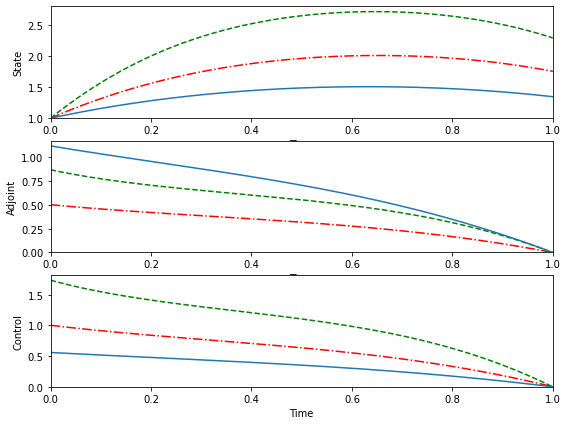

In [3]:
import numpy as np
import matplotlib.pyplot as plt

N = 1000
t = np.linspace(0,1,N+1) # Time variable

def OC_F_B_Sweep(A,B,C):

 #Test represents the convergence test variable
 test = -1
 

 x0 = 1 # Initial value of x.
 delta = 0.001   # Accepted Tolerance

 h = 1/N    # Step size for Runge-Kutta 4 sweep
 h2 = h/2

 u = np.zeros(N+1)     # Initial guess for Control

 x = np.zeros(N+1)     # State
 x[0] = x0     # Stores initial value of State x.

 Lambda = np.zeros(N+1) # Adjoint

 #The while loop begins with the test function. This loop contains the Forward-Backward Sweep. The loop ends once converegence occurs (t>=0).
 while(test < 0):
    
     #Stores the current values of u, x, and lambda as the previous values of u, x, and lambda.
     oldu = u
     oldx = x
     oldLambda = Lambda

     # Generate new values. 

     #Runge-Kutta 4 sweep: Solving x forward in time. x1 is used  to find x2, x2 is used to solve x3 and so on.
     for i in np.arange (0,N):
         k1 = -0.5*x[i]**2 + C*u[i]
         k2 = -0.5*(x[i] + h2*k1)**2 + C*0.5*(u[i] + u[i+1])
         k3 = -0.5*(x[i] + h2*k2)**2 + C*0.5*(u[i] + u[i+1])
         k4 = -0.5*(x[i] + h*k3)**2 + C*u[i+1]
         x[i+1] = x[i] + (h/6)*(k1 + 2*k2 +2*k3 +k4)   
     
     #Runge-Kutta 4 sweep: Solving Lambda backwards in time. Lambda1 is used  to find Lambda2, Lambda2 is used to solve Lambda3 and so on.
     for i in np.arange (0,N):
         j = N + 2 - (i+2)
         k1 = -A + Lambda[j]*x[j]
         k2 = -A + (Lambda[j] - h2*k1)*0.5*(x[j]+x[j-1])
         k3 = -A + (Lambda[j] - h2*k2)*0.5*(x[j]+x[j-1])
         k4 = -A + (Lambda[j] - h*k3)*x[j-1]
         Lambda[j-1] = Lambda[j] - (h/6)*(k1 + 2*k2 + 2*k3 +k4)
        
    
    
     u1 = C*Lambda/(2*B)    #Represents u using the new values  for lambda
     u = 0.5*(u1 + oldu)     # Control 
    
     #Convergence test parameters of each variable.
     temp1 = delta*sum(abs(u)) - sum(abs(oldu - u))
     temp2 = delta*sum(abs(x)) - sum(abs(oldx - x))
     temp3 = delta*sum(abs(Lambda)) - sum(abs(oldLambda - Lambda))
    
     test = min(temp1, min(temp2, temp3))

 #Stores the value of the final vectors.
 y = [x, Lambda, u]
 #y[0] = x
 #y[1] = Lambda
 #y[2] = u
 return y


y1 = OC_F_B_Sweep(A = 1,B = 1,C = 4)

y2 = OC_F_B_Sweep(A = 2,B = 1,C = 4)

y3 = OC_F_B_Sweep(A = 2,B = 4,C = 4)


# Plot Results
plt.figure(figsize=(9,7))  
plt.subplot(3,1,1);plt.plot( t, y1[0], 'r-.', t, y2[0],'g--',  t, y3[0])
plt.subplot(3,1,1);plt.xlabel('Time')
plt.subplot(3,1,1);plt.ylabel('State')
plt.subplot(3,1,1);plt.xlim([0,1])
plt.subplot(3,1,1);plt.ylim(bottom=1)

plt.subplot(3,1,2);plt.plot( t, y1[1], 'r-.', t, y2[1],'g--',  t, y3[1])
plt.subplot(3,1,2);plt.xlabel('Time')
plt.subplot(3,1,2);plt.ylabel('Adjoint')
plt.subplot(3,1,2);plt.xlim([0,1])
plt.subplot(3,1,2);plt.ylim(bottom=0)

plt.subplot(3,1,3);plt.plot( t, y1[2], 'r-.', t, y2[2],'g--',  t, y3[2])
plt.subplot(3,1,3);plt.xlabel('Time')
plt.subplot(3,1,3);plt.ylabel('Control')   
plt.subplot(3,1,3);plt.xlim([0,1])
plt.subplot(3,1,3);plt.ylim(bottom=0)

plt.show()

import warnings
warnings.filterwarnings('ignore')

#### Discussion 
Here we see the plots of the state, adjoint and control. By examining the blue line, we see that the control begins strongly, pushing the state up but it steadily decreases to $0$. The state, undisturbed by the control, will decrease monotonically. This is because the state has two things acting upon it. $-u^2$ pulls it down while Cu pulls it up. Therefore, the state begins to decrease at the end of the interval as the control approaches $0$. The red dotted dashed line shows us that the state begins at the same point, increases then decreases monotonically while the control starts at a higher point then steadily decrease to $0$. This is because by changing A and making it higher, more emphasis is put on increasing x. Lastly as the green dashed line of the state begins lower, we will use less control. Like before, the state still decreases monotonically and the control still decreases to $0$. This is because as the cost B increases the Optimal control decreases.

### Forward-Backward Sweep of the Optimal Control Problem of the SEIR Epidemic Model <a name="OCSEIR"></a>

Let's recall the optimal control pronlem of the SEIR model.
\begin{align*}
\max \int_0^T  AI(t)+u(t)^2 \, dt
\end{align*}
subject to
\begin{align*}
& S' = bN - dS -cSI - uS, \,\, S(0)=S_0 \geq 0, \\
& E' = cSI - (e+d)E, \,\, E(0)=E_0 \geq 0, \\
& I' = eE - (g+a+d)I, \,\, I(0)=I_0 \geq 0, \\
& R' = gI - dR + uS, \,\, R(0)=R_0 \geq 0, \\
& N' = (b-d)N - aI, \,\, N(0)=N_0 \geq 0, \\
& 0 \leq u(t) \leq 0.9.
\end{align*}

Observe that $R$ only appears in $R'$ not $S'$, $E'$, $I'$, or $N'$. Therefore, R can be ignored when solving the optimal control using the Forward-Backward Sweep and instead be solved using its differential equation once convergence is achieved. Before beginning the Forward-Backward Sweep, we first need the necessary conditions. The necessary conditions for this problem are 

<b> Hamiltonian:</b>
    \begin{align*}
        H=AI+u^2+(bN-dS-cSI-us) \lambda_1+(cSI-(e+d)E)) \lambda_2 +(eE-(g+a+d)I) \lambda_3+((b-d)N-aI) \lambda_4
    \end{align*}
    
   <b>Optimality condition:</b>
    \begin{align*}
        0= \frac{\partial H}{\partial u}=2u -S\lambda_1 \Rightarrow u^\ast =\frac{S \lambda_1}{2}
    \end{align*}
    
   <b> Adjoint equations:</b>
    \begin{align*}
       & \lambda_S'(t) =-\frac{\partial H}{\partial S} = (d+cI+u)\lambda_1 - cI\lambda_2 \\
       &\lambda_E'(t) =-\frac{\partial H}{\partial E} = (e+d) \lambda_2 - e\lambda_3\\
       & \lambda_I'(t) =-\frac{\partial H}{\partial I} =-A +(g+a+d)\lambda_3 + cS\lambda_1 -cS\lambda_2 +a\lambda_4\\
       & \lambda_N'(t) =-\frac{\partial H}{\partial N} =-(b-d)\lambda_4 - b\lambda_1\\    
    \end{align*}
    <b>Transversality condition:</b>
    \begin{align*}
        \lambda (T) = 0
    \end{align*}
    
$S$, $E$, $I$, and $N$ are solved forward in time while their adjoints are solved backwards in time.  

#### Code Explanation:
This code is very similar to the code of the basic optimal control problem. The only major differences are that we have four states to solve forward in time, four adjoints to solve backwards in time and one vector that needs to be solved separately. Therefore, as to not repeat too much of the basic code's explanation, only the new material will be explained.

```python
def OC_SEIRN(b, d, c, e, g, a, A, T, S0, E0, I0, R0, N0):
 test = -1
 delta = 0.001   
 M = 1000
 tvec = np.linspace(0,T,M+1) 
 h = 1/M    
 h2 = h/2
 u = np.zeros(M+1)     
 x = np.zeros((M+1,4)) 
 S = np.zeros(M+1)     
 E = np.zeros(M+1)     
 I = np.zeros(M+1)    
 N = np.zeros(M+1)     
 Lambda1 = np.zeros(M+1) 
 Lambda2 = np.zeros(M+1) 
 Lambda3 = np.zeros(M+1) 
 Lambda4 = np.zeros(M+1) 
 Lambda = np.zeros((M+1,4)) 
 R = np.zeros(M+1)
 S[0] = S0    
 E[0] = E0     
 I[0] = I0     
 N[0] = N0     
 while(test < 0):   
```

We begin the code by defining the function $OC_SEIRN$ with the variables $b$, $d$, $c$, $e$, $g$, $a$, $A$, $T$, $S0$, $E0$, $I0$, $R0$, and $N0$ as inputs.  The variables $S$, $E$, $I$ and $N$ will represent the state variables of the susceptible, exposed, infected, and total population, respectively, while $x$ will now represent the state matrix of the state vectors $S$, $E$, $I$ and $N$. The variables $Lambda1$, $Lambda2$, $Lambda3$ and $Lambda4$ will represent the adjoint equations in respect to the susceptible, exposed, infected, and total population, respectively, while $Lambda$ will now represent the adjoint equation matrix of the adjoint vectors $S$, $E$, $I$ and $N$. $R$ represents the recovery rate.

```python
     oldu = u
     oldx = x
     oldLambda = Lambda
```

The variables $u$, $x$, and $Lambda$ will be stored in $oldu$, $oldx$, $oldLambda$, respectively. Since we are combing all of the states and adjoints into their own matrices, we do not need to store the other states and adjoints. Therefore, only the previous iterations of $u$, $x$, and $Lambda$ will be recorded.

```python
     for i in np.arange (0,M):
         k11 = b*N[i] - (d + c*I[i] + u[i])*S[i]
         k12 = c*S[i]*I[i] - (e + d)*E[i]
         k13 = e*E[i] - (g + a + d)*I[i]
         k14 = (b - d)*N[i] - a*I[i]
         k21 = b*(N[i] + h2*k14) - (d + c*(I[i] + h2*k13) + 0.5*(u[i] + u[i+1]))*(S[i] + h2*k11)
         k22 = c*(S[i] + h2*k11)*(I[i] + h2*k13) - (e + d)*(E[i] + h2*k12)
         k23 = e*(E[i] + h2*k12) - (g + a + d)*(I[i] + h2*k13)
         k24 = (b - d)*(N[i] +h2*k14) - a*(I[i] + h2*k13)
         k31 = b*(N[i] + h2*k24) - (d + c*(I[i] + h2*k23) + 0.5*(u[i] + u[i+1]))*(S[i] + h2*k21)
         k32 = c*(S[i] + h2*k21)*(I[i] + h2*k23) - (e + d)*(E[i] + h2*k22)
         k33 = e*(E[i] + h2*k22) - (g + a + d)*(I[i] + h2*k23)
         k34 = (b - d)*(N[i] +h2*k24) - a*(I[i] + h2*k23)
         k41 = b*(N[i] + h*k34) - (d + c*(I[i] + h*k33) + u[i+1])*(S[i] + h*k31)
         k42 = c*(S[i] + h*k31)*(I[i] + h*k33) - (e + d)*(E[i] + h*k32)
         k43 = e*(E[i] + h*k32) - (g + a + d)*(I[i] + h*k33)
         k44 = (b - d)*(N[i] +h*k34) - a*(I[i] + h*k33)
         S[i+1] = S[i] + (h/6)*(k11 + 2*k21 +2*k31 +k41) 
         E[i+1] = E[i] + (h/6)*(k12 + 2*k22 +2*k32 +k42) 
         I[i+1] = I[i] + (h/6)*(k13 + 2*k23 +2*k33 +k43) 
         N[i+1] = N[i] + (h/6)*(k14 + 2*k24 +2*k34 +k44)   
    
```
The next two section will focus on the Runge-Kutta 4 Sweep. The variable $ki1$, for $i=1, 2, 3, 4$, represents the Runge-Kutta 4 Sweep for the DE $S'$. The variable $ki2$, for $i=1, 2, 3, 4$, represents the Runge-Kutta 4 Sweep for the DE $E'$. The variable $ki3$, for $i=1, 2, 3, 4$, represents the Runge-Kutta 4 Sweep for the DE $I'$. The variable $ki4$, for $i=1, 2, 3, 4$, represents the Runge-Kutta 4 Sweep for the DE $N'$.


```python
     for i in np.arange (0,M):
         j = M + 2 - (i+2)
         k11 = (d + c + u[j])*Lambda1[j] - c*Lambda2[j]*I[j]
         k12 = (e + d)*Lambda2[j] - e*Lambda3[j]
         k13 = -A + (g + a + d)*Lambda3[j] + c*Lambda1[j]*S[j] - c*Lambda2[j]*S[j] + a*Lambda4[j]
         k14 = -(b - d)*Lambda4[j] - b*Lambda1[j]
         k21 = (d + c + 0.5*(u[j] + u[j-1]))*(Lambda1[j] - h2*k11) - c*(Lambda2[j] - h2*k12)*0.5*(I[j] + I[j-1])
         k22 = (e + d)*(Lambda2[j] - h2*k12) - e*(Lambda3[j] - h2*k13)
         k23 = -A + (g + a + d)*(Lambda3[j] - h2*k13) + c*(Lambda1[j] - h2*k11)*0.5*(S[j] + S[j-1]) - c*(Lambda2[j] -h2*k12)*0.5*(S[j] + S[j-1]) + a*(Lambda4[j] - h2*k14)
         k24 = -(b - d)*(Lambda4[j] - h2*k14) - b*(Lambda1[j] - h2*k11)
         k31 = (d + c + 0.5*(u[j] + u[j-1]))*(Lambda1[j] - h2*k21) - c*(Lambda2[j] - h2*k22)*0.5*(I[j] + I[j-1])
         k32 = (e + d)*(Lambda2[j] - h2*k22) - e*(Lambda3[j] - h2*k23)
         k33 = -A + (g + a + d)*(Lambda3[j] - h2*k23) + c*(Lambda1[j] - h2*k21)*0.5*(S[j] + S[j-1]) - c*(Lambda2[j] -h2*k22)*0.5*(S[j] + S[j-1]) + a*(Lambda4[j] - h2*k24)
         k34 = -(b - d)*(Lambda4[j] - h2*k24) - b*(Lambda1[j] - h2*k21)
         k41 = (d + c + u[j-1])*(Lambda1[j] - h*k31) - c*(Lambda2[j] - h*k32)* I[j-1]
         k42 = (e + d)*(Lambda2[j] - h*k32) - e*(Lambda3[j] - h*k33)
         k43 = -A + (g + a + d)*(Lambda3[j] - h*k33) + c*(Lambda1[j] - h*k31)*S[j-1] - c*(Lambda2[j] - h*k32)*S[j-1] + a*(Lambda4[j] - h*k34)
         k44 = -(b - d)*(Lambda4[j] - h*k34) - b*(Lambda1[j] - h*k31)
         Lambda1[j-1] = Lambda1[j] - (h/6)*(k11 + 2*k21 + 2*k31 +k41)
         Lambda2[j-1] = Lambda2[j] - (h/6)*(k12 + 2*k22 + 2*k32 +k42)
         Lambda3[j-1] = Lambda3[j] - (h/6)*(k13 + 2*k23 + 2*k33 +k43)
         Lambda4[j-1] = Lambda4[j] - (h/6)*(k14 + 2*k24 + 2*k34 +k44)
    
```

The variable $ki1$, for $i=1, 2, 3, 4$, represents the Runge-Kutta 4 Sweep for the DE $\lambda_S'$. The variable $ki2$, for $i=1, 2, 3, 4$, represents the Runge-Kutta 4 Sweep for the DE $\lambda_E'$. The variable $ki3$, for $i=1, 2, 3, 4$, represents the Runge-Kutta 4 Sweep for the DE $\lambda_I'$. The variable $ki4$, for $i=1, 2, 3, 4$, represents the Runge-Kutta 4 Sweep for the DE $\lambda_N'$. Note that in $\lambda_S'$ we have the variable $u$. This is not like the basic code. Since $u$ is a function of time, we will approximate the $u$ by taking the average $u$ of the $i$ grid point and the $u$ of the $i+1$ grid point.

```python
     SEIN = np.array([S,E,I,N])
     x = SEIN.transpose()
     Lam1_4 = np.array([Lambda1,Lambda2,Lambda3,Lambda4])
     Lambda = Lam1_4.transpose()
     y = x[:,0]
     z = Lambda[:,0]
```
Now we will create the state and adjoint matrices. The variable $SEIN$ will store the $S$, $E$, $I$, and $N$ variables from the Forward-Backward Sweep, while the variable $LambdaSEIN$ will store the $LambdaS$, $LambdaE$, $LambdaI$, and $LambdaN$ variables. Unfortunately, the matrices have the rows and columns switched from what we need. So we assign the variables $x$ and $Lambda$ as the transpose of the $SEIN$ and $LambdaSEIN$ matrices, respectively.

```python
     temp = (y*z)/2       
     m = np.zeros(M+1)                 
     for i in np.arange (0,M+1):
           m[i] = min(0.9, max(0,temp[i]))
           u1 =m       
           u = 0.5*(u1 + oldu)     
     temp1 = delta*LA.norm(u) - LA.norm(oldu - u)
     temp2 = delta*LA.norm(x) - LA.norm(oldx - x)
     temp3 = delta*LA.norm(Lambda) - LA.norm(oldLambda - Lambda)
     test = min(temp1, min(temp2, temp3))     
```

The variable $y$ represents the $S$ column in $x$ and the variable $z$ represents the $LambdaS$ column in $Lambda$. Since our optimality condition comes from $S$ and $\lambda_S$, we will only need to use these to find the optimal control, $u^*$.  This is where the variable $temp$ comes in. Recall that $u$ is bounded between $0$ and $0.9$ (i.e. $0 \leq u(t) \leq 0.9$). To represent this, a for loop was created to find the minimum value between $0.9$, $0$, and the vector $u$. This will be on a term-by-term bases for $u$.

```python
  R = x[:,3] - x[:,1] - x[:,2] - x[:,0]
 y = [x[:,0], x[:,1], x[:,2], x[:,3], R, u, tvec]
 return y
y1 = OC_SEIRN(b = 0.525, d = 0.5, c = 0.0001, e = 0.5, g = 0.1, a = 0.2, A = 0.1, T = 20, S0 = 1000, E0 = 100, I0 = 50, R0 = 15, N0 = 1165)
y2 = OC_SEIRN(b = 0.525, d = 0.5, c = 0.001, e = 0.5, g = 0.1, a = 0.2, A = 0.1, T = 20, S0 = 1000, E0 = 100, I0 = 50, R0 = 15, N0 = 1165)
y3 = OC_SEIRN(b = 0.525, d = 0.5, c = 0.001, e = 0.5, g = 0.1, a = 0.2, A = 0.1, T = 20, S0 = 1000, E0 = 1000, I0 = 2000, R0 = 500, N0 = 1165)
y4 = OC_SEIRN(b = 0.525, d = 0.5, c = 0.001, e = 0.5, g = 0.1, a = 0.2, A = 0.1, T = 20, S0 = 1000, E0 = 2000, I0 = 5000, R0 = 1000, N0 = 1165)
```

Lastly, we will solve for the variable $R$ using $R = N - S - E - I$ and store the final values in $y$. The variables $y1$, $y2$, $y3$, $y4$ run the function with different values for $b$, $d$, $c$, $e$, $g$, $a$, $A$, $T$, $S0$, $E0$, $I0$, $R0$, and $N0$.

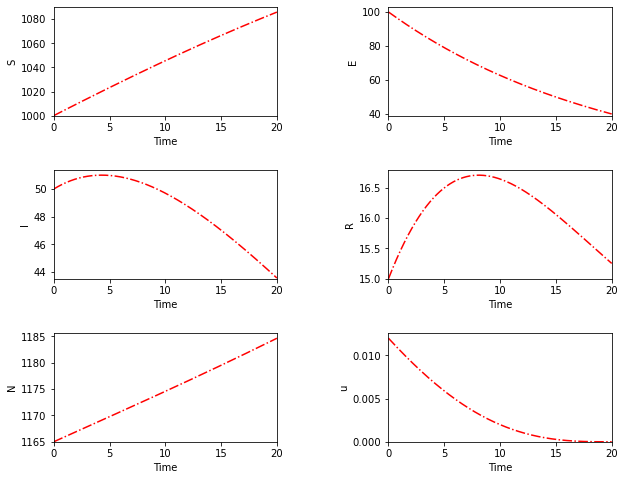

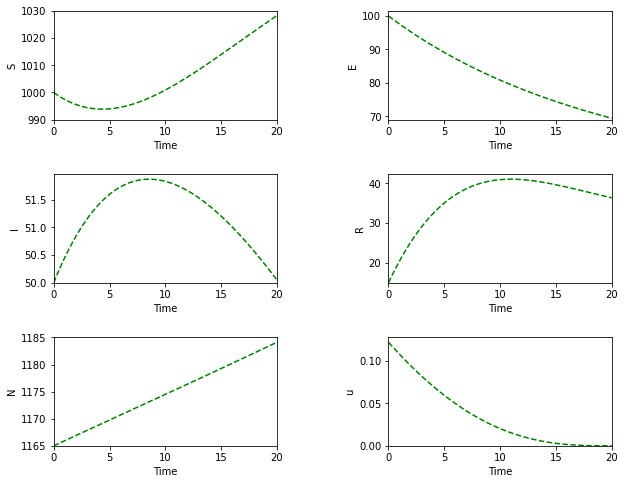

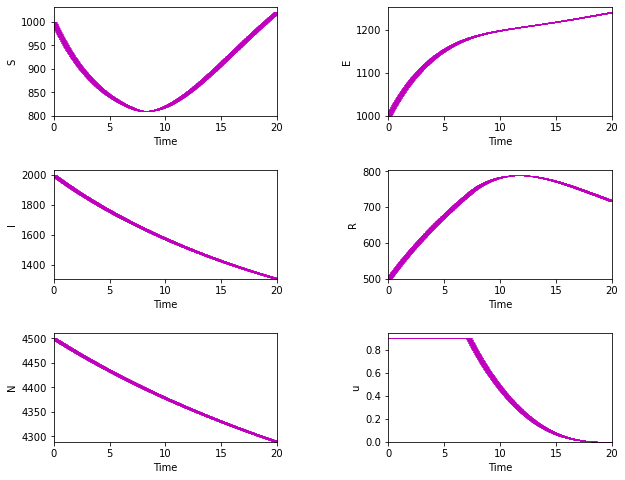

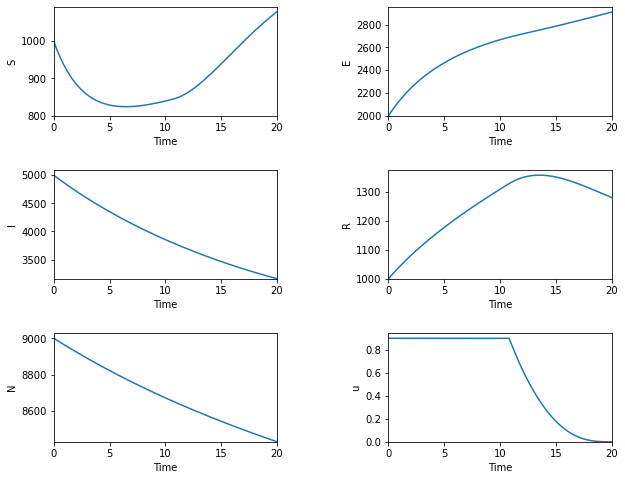

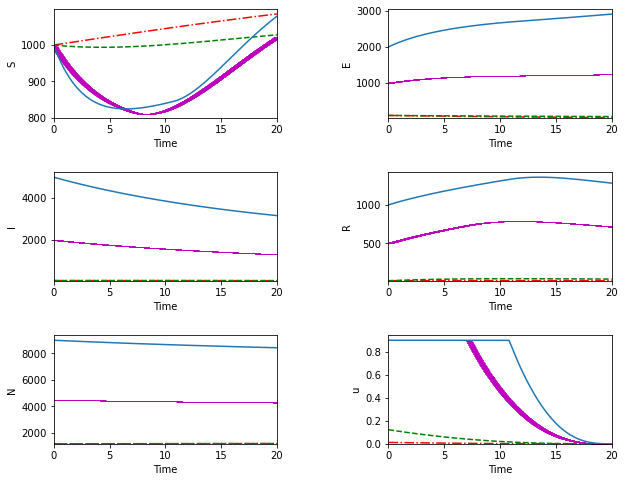

In [5]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt


def OC_SEIRN(b, d, c, e, g, a, A, T, S0, E0, I0, R0, N0):
 #Test represents the convergence test variable
 test = -1

 delta = 0.001   # Accepted Tolerance
 M = 1000

 t = np.linspace(0,T,M+1) # Time variable
 h = 1/M    # Step size for Runge-Kutta 4 sweep
 h2 = h/2


 u = np.zeros(M+1)     # Initial guess for Control
 x = np.zeros((M+1,4)) # State
 S = np.zeros(M+1)     # State S
 E = np.zeros(M+1)     # State E
 I = np.zeros(M+1)     # State I
 N = np.zeros(M+1)     # State N

 LambdaS = np.zeros(M+1) # Adjoint of S
 LambdaE = np.zeros(M+1) # Adjoint of E
 LambdaI = np.zeros(M+1) # Adjoint of I
 LambdaN = np.zeros(M+1) # Adjoint of N
 Lambda = np.zeros((M+1,4))  # Adjoint

 R = np.zeros(M+1)    # Recovery rate 

 S[0] = S0     # Stores initial value of State S.
 E[0] = E0     # Stores initial value of State E.
 I[0] = I0     # Stores initial value of State I.
 N[0] = N0     # Stores initial value of State N.



 #The while loop begins with the test function. This loop contains the Forward-Backward Sweep. The loop ends once converegence occurs (t>=0).
 while(test < 0):
    
     #Stores the current values of u, S, E, I, N, Lambda1, Lambda2, Lambda3, Lambda4, x, and Lambda as the previous values of u, x, and lambda.
     oldu = u
     oldx = x
     oldLambda = Lambda

     # Generate new values. 

     #Runge-Kutta 4 sweep: Solving x forward in time. x1 is used  to find x2, x2 is used to solve x3 and so on.
     for i in np.arange (0,M):
         k11 = b*N[i] - (d + c*I[i] + u[i])*S[i]
         k12 = c*S[i]*I[i] - (e + d)*E[i]
         k13 = e*E[i] - (g + a + d)*I[i]
         k14 = (b - d)*N[i] - a*I[i]

         k21 = b*(N[i] + h2*k14) - (d + c*(I[i] + h2*k13) + 0.5*(u[i] + u[i+1]))*(S[i] + h2*k11)
         k22 = c*(S[i] + h2*k11)*(I[i] + h2*k13) - (e + d)*(E[i] + h2*k12)
         k23 = e*(E[i] + h2*k12) - (g + a + d)*(I[i] + h2*k13)
         k24 = (b - d)*(N[i] +h2*k14) - a*(I[i] + h2*k13)

         k31 = b*(N[i] + h2*k24) - (d + c*(I[i] + h2*k23) + 0.5*(u[i] + u[i+1]))*(S[i] + h2*k21)
         k32 = c*(S[i] + h2*k21)*(I[i] + h2*k23) - (e + d)*(E[i] + h2*k22)
         k33 = e*(E[i] + h2*k22) - (g + a + d)*(I[i] + h2*k23)
         k34 = (b - d)*(N[i] +h2*k24) - a*(I[i] + h2*k23)

         k41 = b*(N[i] + h*k34) - (d + c*(I[i] + h*k33) + u[i+1])*(S[i] + h*k31)
         k42 = c*(S[i] + h*k31)*(I[i] + h*k33) - (e + d)*(E[i] + h*k32)
         k43 = e*(E[i] + h*k32) - (g + a + d)*(I[i] + h*k33)
         k44 = (b - d)*(N[i] +h*k34) - a*(I[i] + h*k33)

         S[i+1] = S[i] + (h/6)*(k11 + 2*k21 +2*k31 +k41) 
         E[i+1] = E[i] + (h/6)*(k12 + 2*k22 +2*k32 +k42) 
         I[i+1] = I[i] + (h/6)*(k13 + 2*k23 +2*k33 +k43) 
         N[i+1] = N[i] + (h/6)*(k14 + 2*k24 +2*k34 +k44)   
    
     #Runge-Kutta 4 sweep: Solving Lambda backwards in time. LambdaS is used  to find LambdaE, LambdaE is used to solve LambdaI and so on.
     for i in np.arange (0,M):
         j = M + 2 - (i+2)
         k11 = (d + c + u[j])*LambdaS[j] - c*LambdaE[j]*I[j]
         k12 = (e + d)*LambdaE[j] - e*LambdaI[j]
         k13 = -A + (g + a + d)*LambdaI[j] + c*LambdaS[j]*S[j] - c*LambdaE[j]*S[j] + a*LambdaN[j]
         k14 = -(b - d)*LambdaN[j] - b*LambdaS[j]

         k21 = (d + c + 0.5*(u[j] + u[j-1]))*(LambdaS[j] - h2*k11) - c*(LambdaE[j] - h2*k12)*0.5*(I[j] + I[j-1])
         k22 = (e + d)*(LambdaE[j] - h2*k12) - e*(LambdaI[j] - h2*k13)
         k23 = -A + (g + a + d)*(LambdaI[j] - h2*k13) + c*(LambdaS[j] - h2*k11)*0.5*(S[j] + S[j-1]) - c*(LambdaE[j] - h2*k12)*0.5*(S[j] + S[j-1]) + a*(LambdaN[j] - h2*k14)
         k24 = -(b - d)*(LambdaN[j] - h2*k14) - b*(LambdaS[j] - h2*k11)

         k31 = (d + c + 0.5*(u[j] + u[j-1]))*(LambdaS[j] - h2*k21) - c*(LambdaE[j] - h2*k22)*0.5*(I[j] + I[j-1])
         k32 = (e + d)*(LambdaE[j] - h2*k22) - e*(LambdaI[j] - h2*k23)
         k33 = -A + (g + a + d)*(LambdaI[j] - h2*k23) + c*(LambdaS[j] - h2*k21)*0.5*(S[j] + S[j-1]) - c*(LambdaE[j] - h2*k22)*0.5*(S[j] + S[j-1]) + a*(LambdaN[j] - h2*k24)
         k34 = -(b - d)*(LambdaN[j] - h2*k24) - b*(LambdaS[j] - h2*k21)

         k41 = (d + c + u[j-1])*(LambdaS[j] - h*k31) - c*(LambdaE[j] - h*k32)* I[j-1]
         k42 = (e + d)*(LambdaE[j] - h*k32) - e*(LambdaI[j] - h*k33)
         k43 = -A + (g + a + d)*(LambdaI[j] - h*k33) + c*(LambdaS[j] - h*k31)*S[j-1] - c*(LambdaE[j] - h*k32)*S[j-1] + a*(LambdaN[j] - h*k34)
         k44 = -(b - d)*(LambdaN[j] - h*k34) - b*(LambdaS[j] - h*k31)

         LambdaS[j-1] = LambdaS[j] - (h/6)*(k11 + 2*k21 + 2*k31 +k41)
         LambdaE[j-1] = LambdaE[j] - (h/6)*(k12 + 2*k22 + 2*k32 +k42)
         LambdaI[j-1] = LambdaI[j] - (h/6)*(k13 + 2*k23 + 2*k33 +k43)
         LambdaN[j-1] = LambdaN[j] - (h/6)*(k14 + 2*k24 + 2*k34 +k44)
    
     # Make SEIN and Lambda1-4 into transpose matrices
     SEIN = np.array([S,E,I,N])
     x = SEIN.transpose()
     LamSEIN = np.array([LambdaS,LambdaE,LambdaI,LambdaN])
     Lambda = LamSEIN.transpose()

     # Optimal Control
     w = x[:,0]          #Stores the susceptible
     z = Lambda[:,0]     #Stores the Lambda of the susceptible

     temp = (w*z)/2       #Represents the characterization of u 

     m = np.zeros(M+1)                 
     for i in np.arange (0,M+1):       #Represents u and it's bounds i.e 0<= u* <= 0.9
           m[i] = min(0.9, max(0,temp[i]))
           u1 = m       

           u = 0.5*(u1 + oldu)     # Control 
    
     #Convergence test parameters of each variable.
     temp1 = delta*LA.norm(u) - LA.norm(oldu - u)
     temp2 = delta*LA.norm(x) - LA.norm(oldx - x)
     temp3 = delta*LA.norm(Lambda) - LA.norm(oldLambda - Lambda)
    

     test = min(temp1, min(temp2, temp3))     
    


 #Solving for R where R = N - S - E - I
 R = x[:,3] - x[:,1] - x[:,2] - x[:,0]

 y = [x[:,0], x[:,1], x[:,2], x[:,3], R, u, t]
 return y

y1 = OC_SEIRN(b = 0.525, d = 0.5, c = 0.0001, e = 0.5, g = 0.1, a = 0.2, A = 0.1, T = 20, S0 = 1000, E0 = 100, I0 = 50, R0 = 15, N0 = 1165)

y2 = OC_SEIRN(b = 0.525, d = 0.5, c = 0.001, e = 0.5, g = 0.1, a = 0.2, A = 0.1, T = 20, S0 = 1000, E0 = 100, I0 = 50, R0 = 15, N0 = 1165)

y3 = OC_SEIRN(b = 0.525, d = 0.5, c = 0.001, e = 0.5, g = 0.1, a = 0.2, A = 0.1, T = 20, S0 = 1000, E0 = 1000, I0 = 2000, R0 = 500, N0 = 4500)

y4 = OC_SEIRN(b = 0.525, d = 0.5, c = 0.001, e = 0.5, g = 0.1, a = 0.2, A = 0.1, T = 20, S0 = 1000, E0 = 2000, I0 = 5000, R0 = 1000, N0 = 9000)


##Plot Results##
#Change figure size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

plt.figure(1)           #Plot of y1

#plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=None,hspace=None)
#This is used to fix the spacing of the subplots
plt.subplots_adjust(None,None,None,None,0.5,0.5)    

plt.subplot(3,2,1);plt.plot(y1[6], y1[0], 'r-.')
plt.subplot(3,2,1);plt.xlabel('Time')
plt.subplot(3,2,1);plt.ylabel('S')
plt.subplot(3,2,1);plt.xlim([0,20])
plt.subplot(3,2,1);plt.ylim(bottom=1000)

plt.subplot(3,2,2);plt.plot(y1[6], y1[1], 'r-.')
plt.subplot(3,2,2);plt.xlabel('Time')
plt.subplot(3,2,2);plt.ylabel('E')
plt.subplot(3,2,2);plt.xlim([0,20])
plt.subplot(3,2,2);plt.ylim(bottom=39)

plt.subplot(3,2,3);plt.plot(y1[6], y1[2], 'r-.')
plt.subplot(3,2,3);plt.xlabel('Time')
plt.subplot(3,2,3);plt.ylabel('I')   
plt.subplot(3,2,3);plt.xlim([0,20])
plt.subplot(3,2,3);plt.ylim(bottom=43.5)

plt.subplot(3,2,4);plt.plot(y1[6], y1[4], 'r-.')
plt.subplot(3,2,4);plt.xlabel('Time')
plt.subplot(3,2,4);plt.ylabel('R')
plt.subplot(3,2,4);plt.xlim([0,20])
plt.subplot(3,2,4);plt.ylim(bottom=15)

plt.subplot(3,2,5);plt.plot(y1[6], y1[3], 'r-.')
plt.subplot(3,2,5);plt.xlabel('Time')
plt.subplot(3,2,5);plt.ylabel('N')
plt.subplot(3,2,5);plt.xlim([0,20])
plt.subplot(3,2,5);plt.ylim(bottom=1165)

plt.subplot(3,2,6);plt.plot(y1[6], y1[5], 'r-.')
plt.subplot(3,2,6);plt.xlabel('Time')
plt.subplot(3,2,6);plt.ylabel('u')   
plt.subplot(3,2,6);plt.xlim([0,20])
plt.subplot(3,2,6);plt.ylim(bottom=0)
#---------------------------------------------------------------------------------------------------
plt.figure(2)       #Plot of y2
plt.subplots_adjust(None,None,None,None,0.5,0.5)    

plt.subplot(3,2,1);plt.plot(y2[6], y2[0],'g--')
plt.subplot(3,2,1);plt.xlabel('Time')
plt.subplot(3,2,1);plt.ylabel('S')
plt.subplot(3,2,1);plt.xlim([0,20])
plt.subplot(3,2,1);plt.ylim(bottom=990)

plt.subplot(3,2,2);plt.plot(y2[6], y2[1],'g--')
plt.subplot(3,2,2);plt.xlabel('Time')
plt.subplot(3,2,2);plt.ylabel('E')
plt.subplot(3,2,2);plt.xlim([0,20])
plt.subplot(3,2,2);plt.ylim(bottom=69)

plt.subplot(3,2,3);plt.plot(y2[6], y2[2],'g--')
plt.subplot(3,2,3);plt.xlabel('Time')
plt.subplot(3,2,3);plt.ylabel('I')   
plt.subplot(3,2,3);plt.xlim([0,20])
plt.subplot(3,2,3);plt.ylim(bottom=50)

plt.subplot(3,2,4);plt.plot(y2[6], y2[4],'g--')
plt.subplot(3,2,4);plt.xlabel('Time')
plt.subplot(3,2,4);plt.ylabel('R')
plt.subplot(3,2,4);plt.xlim([0,20])
plt.subplot(3,2,4);plt.ylim(bottom=15)

plt.subplot(3,2,5);plt.plot(y2[6], y2[3],'g--')
plt.subplot(3,2,5);plt.xlabel('Time')
plt.subplot(3,2,5);plt.ylabel('N')
plt.subplot(3,2,5);plt.xlim([0,20])
plt.subplot(3,2,5);plt.ylim(bottom=1165)

plt.subplot(3,2,6);plt.plot(y2[6], y2[5],'g--')
plt.subplot(3,2,6);plt.xlabel('Time')
plt.subplot(3,2,6);plt.ylabel('u')   
plt.subplot(3,2,6);plt.xlim([0,20])
plt.subplot(3,2,6);plt.ylim(bottom=0)
#---------------------------------------------------------------------------------------------------
plt.figure(3)          #Plot of y3
plt.subplots_adjust(None,None,None,None,0.5,0.5)    

plt.subplot(3,2,1);plt.plot(y3[6], y3[0], 'm_')
plt.subplot(3,2,1);plt.xlabel('Time')
plt.subplot(3,2,1);plt.ylabel('S')
plt.subplot(3,2,1);plt.xlim([0,20])
plt.subplot(3,2,1);plt.ylim(bottom=800)

plt.subplot(3,2,2);plt.plot(y3[6], y3[1], 'm_')
plt.subplot(3,2,2);plt.xlabel('Time')
plt.subplot(3,2,2);plt.ylabel('E')
plt.subplot(3,2,2);plt.xlim([0,20])
plt.subplot(3,2,2);plt.ylim(bottom=1000)

plt.subplot(3,2,3);plt.plot(y3[6], y3[2], 'm_')
plt.subplot(3,2,3);plt.xlabel('Time')
plt.subplot(3,2,3);plt.ylabel('I')   
plt.subplot(3,2,3);plt.xlim([0,20])
plt.subplot(3,2,3);plt.ylim(bottom=1307)

plt.subplot(3,2,4);plt.plot(y3[6], y3[4], 'm_')
plt.subplot(3,2,4);plt.xlabel('Time')
plt.subplot(3,2,4);plt.ylabel('R')
plt.subplot(3,2,4);plt.xlim([0,20])
plt.subplot(3,2,4);plt.ylim(bottom=500)

plt.subplot(3,2,5);plt.plot(y3[6], y3[3], 'm_')
plt.subplot(3,2,5);plt.xlabel('Time')
plt.subplot(3,2,5);plt.ylabel('N')
plt.subplot(3,2,5);plt.xlim([0,20])
plt.subplot(3,2,5);plt.ylim(bottom=4289)

plt.subplot(3,2,6);plt.plot(y3[6], y3[5], 'm_')
plt.subplot(3,2,6);plt.xlabel('Time')
plt.subplot(3,2,6);plt.ylabel('u')   
plt.subplot(3,2,6);plt.xlim([0,20])
plt.subplot(3,2,6);plt.ylim(bottom=0)
#------------------------------------------------------------------------------------------------------
plt.figure(4)            #Plot of y4
plt.subplots_adjust(None,None,None,None,0.5,0.5)    

plt.subplot(3,2,1);plt.plot(y4[6], y4[0])
plt.subplot(3,2,1);plt.xlabel('Time')
plt.subplot(3,2,1);plt.ylabel('S')
plt.subplot(3,2,1);plt.xlim([0,20])
plt.subplot(3,2,1);plt.ylim(bottom=800)

plt.subplot(3,2,2);plt.plot(y4[6], y4[1])
plt.subplot(3,2,2);plt.xlabel('Time')
plt.subplot(3,2,2);plt.ylabel('E')
plt.subplot(3,2,2);plt.xlim([0,20])
plt.subplot(3,2,2);plt.ylim(bottom=2000)

plt.subplot(3,2,3);plt.plot(y4[6], y4[2])
plt.subplot(3,2,3);plt.xlabel('Time')
plt.subplot(3,2,3);plt.ylabel('I')   
plt.subplot(3,2,3);plt.xlim([0,20])
plt.subplot(3,2,3);plt.ylim(bottom=3160)

plt.subplot(3,2,4);plt.plot(y4[6], y4[4])
plt.subplot(3,2,4);plt.xlabel('Time')
plt.subplot(3,2,4);plt.ylabel('R')
plt.subplot(3,2,4);plt.xlim([0,20])
plt.subplot(3,2,4);plt.ylim(bottom=1000)

plt.subplot(3,2,5);plt.plot(y4[6], y4[3])
plt.subplot(3,2,5);plt.xlabel('Time')
plt.subplot(3,2,5);plt.ylabel('N')
plt.subplot(3,2,5);plt.xlim([0,20])
plt.subplot(3,2,5);plt.ylim(bottom=8431)

plt.subplot(3,2,6);plt.plot(y4[6], y4[5])
plt.subplot(3,2,6);plt.xlabel('Time')
plt.subplot(3,2,6);plt.ylabel('u')   
plt.subplot(3,2,6);plt.xlim([0,20])
plt.subplot(3,2,6);plt.ylim(bottom=0)
#-----------------------------------------------------------------------------------------
plt.figure(5)      #Plot of y1 - y4 
plt.subplots_adjust(None,None,None,None,0.5,0.5)    

plt.subplot(3,2,1);plt.plot(y1[6], y1[0], 'r-.', y2[6], y2[0],'g--', y3[6], y3[0], 'm_', y4[6], y4[0])
plt.subplot(3,2,1);plt.xlabel('Time')
plt.subplot(3,2,1);plt.ylabel('S')
plt.subplot(3,2,1);plt.xlim([0,20])
plt.subplot(3,2,1);plt.ylim(bottom=800)

plt.subplot(3,2,2);plt.plot(y1[6], y1[1], 'r-.', y2[6], y2[1],'g--', y3[6], y3[1], 'm_', y4[6], y4[1])
plt.subplot(3,2,2);plt.xlabel('Time')
plt.subplot(3,2,2);plt.ylabel('E')
plt.subplot(3,2,2);plt.xlim([0,20])
plt.subplot(3,2,2);plt.ylim(bottom=39)

plt.subplot(3,2,3);plt.plot(y1[6], y1[2], 'r-.', y2[6], y2[2],'g--',  y3[6], y3[2], 'm_', y4[6], y4[2])
plt.subplot(3,2,3);plt.xlabel('Time')
plt.subplot(3,2,3);plt.ylabel('I')   
plt.subplot(3,2,3);plt.xlim([0,20])
plt.subplot(3,2,3);plt.ylim(bottom=43.5)

plt.subplot(3,2,4);plt.plot(y1[6], y1[4], 'r-.', y2[6], y2[4],'g--', y3[6], y3[4], 'm_', y4[6], y4[4])
plt.subplot(3,2,4);plt.xlabel('Time')
plt.subplot(3,2,4);plt.ylabel('R')
plt.subplot(3,2,4);plt.xlim([0,20])
plt.subplot(3,2,4);plt.ylim(bottom=15)

plt.subplot(3,2,5);plt.plot(y1[6], y1[3], 'r-.', y2[6], y2[3],'g--', y3[6], y3[3], 'm_', y4[6], y4[3])
plt.subplot(3,2,5);plt.xlabel('Time')
plt.subplot(3,2,5);plt.ylabel('N')
plt.subplot(3,2,5);plt.xlim([0,20])
plt.subplot(3,2,5);plt.ylim(bottom=1165)

plt.subplot(3,2,6);plt.plot(y1[6], y1[5], 'r-.', y2[6], y2[5],'g--', y3[6], y3[5], 'm_', y4[6], y4[5])
plt.subplot(3,2,6);plt.xlabel('Time')
plt.subplot(3,2,6);plt.ylabel('u')   
plt.subplot(3,2,6);plt.xlim([0,20])
plt.subplot(3,2,6);plt.ylim(bottom=0)

plt.show()

import warnings
warnings.filterwarnings('ignore')

#### Discussion
In figure $1$ (red), our parameters and initial conditions are $b = 0.525$, $d = 0.5$, $c = 0.0001$, $e = 0.5$, $g = 0.1$, $a = 0.2$, $A = 0.1$, $T = 20$, $S0 = 1000$, $E0 = 100$, $I0 = 50$, $R0 = 15$, and $N0 = 1165$.  We begin with a higher number of initial susceptible individuals than infected, exposed or recovered. In this simulation from year $0$ to $20$ of the epidemic, the population and the number of susceptible individuals steadily increases, while the number of exposed individuals steadily decreases or die out due to death or recovery. The number of infected individuals increases from year $0$ to about year $5$. By year $5$, the infected individuals also begin to die out. In the beginning of the epidemic more than $0.010$ percent of susceptible individuals were being vaccinated. This caused an increase in the number of recovered individuals. As the years go by, the percentage of vaccinated susceptible individuals, $u$, slowly decreases then end. This causes the number of recovered to decrease and slowly vanish. There is still a small amount of infected and exposed individuals but not enough to spread the disease. This is a simulation of an SEIR (or SEIRN) where the number of susceptible individuals outnumber the number of exposed, infected and recovered.

In figure $2$ (green), our parameters and initial conditions are $b = 0.525$, $d = 0.5$, $c = 0.001$, $e = 0.5$, $g = 0.1$, $a = 0.2$, $A = 0.1$, $T = 20$, $S0 = 1000$, $E0 = 100$, $I0 = 50$, $R0 = 15$, and $N0 = 1165$. The only difference between the parameters of figure $1$ and $2$ is that c as increased to $0.001$. This causes the spread of the disease to be more serious, since we have increased the number of infections caused by the infected. In this simulation, the number of exposed and the total population are the same as figure $1$. The number of susceptible individuals slightly decreases from year $0$ to year $5$ then steadily increases. This is due to a good number of susceptible individuals being exposed or being vaccinated. The number of infected individuals increases from year $0$ to about year $8$. By year $10$, the infected individuals also begin to die out. At year $0$, more than $0.10$ percent of susceptible individuals were being vaccinated. This causes a rapid increase in the number of recovered individuals. As the years go by, the percentage of vaccinated susceptible individuals, $u$, slowly decreases then end. This causes the number of recovered to decrease slightly, but it does not fully vanish. By year $20$, the number of recovered individuals make up a good portion of the total population. This is a simulation of what could happen if the amount of infections from the infected increase.

In figure $3$ (purple), our parameters and initial conditions are $b = 0.525$, $d = 0.5$, $c = 0.001$, $e = 0.5$, $g = 0.1$, $a = 0.2$, $A = 0.1$, $T = 20$, $S0 = 1000$, $E0 = 1000$, $I0 = 2000$, $R0 = 500$, and $N0 = 4500$.  We begin with a higher number of initial infected, exposed and recovered individuals. This is different than figures $1$ and $2$ where the number of susceptible individuals took up more of the total population. In this simulation, we see that the number of susceptible individuals rapidly decrease from year $0$ to year $8$ then steadily increases. The number of exposed individuals rapidly increases in the first $5$ years and slowly increases for the rest of the time. The number of infected individuals steadily decreases over the entire time period. The percentage of vaccinated susceptible individuals, $u$, is at the upper bound $0.9$ for the first $7.5$ years then steadily decreases to $0$ by year $20$. This causes a rapid increase in the number of recovered individuals until year $11$ then slowly starts to decrease. The scariest aspect of this simulation is that the total population is steadily decreasing the entire time step. This is a simulation of what can happen when a disease is allowed to spread for a while before a vaccination is introduced.

In figure $4$ (blue), our parameters and initial conditions are $b = 0.525$, $d = 0.5$, $c = 0.001$, $e = 0.5$, $g = 0.1$, $a = 0.2$, $A = 0.1$, $T = 20$, $S0 = 1000$, $E0 = 2000$, $I0 = 5000$, $R0 = 1000$, and $N0 = 9000$. We begin with an even higher number of initial infected, exposed and recovered individuals. In this simulation, we see that the number of susceptible individuals rapidly decrease from year $0$ to year $5.5$, slowly increase from year $5.5$ to year $11$, then steadily increases. The number of exposed individuals steadily increases over the entire time period. The number of infected individuals steadily decreases over the entire time period. The percentage of vaccinated susceptible individuals, $u$, is at the upper bound $0.9$ for the first $11$ years then steadily decreases to $0$ by year $20$. This causes a rapid increase in the number of recovered individuals until year $12.5$ then slowly starts to decrease. Again, the total population is steadily decreasing the entire time step. This is a simulation of what can happen when the vaccination is introduced too late.

In figure $5$ (combo), we can see all $4$ of the simulations at once.


### Conclusion <a name="C2"></a>
In the above simulations, we only used the SEIR (or SEIRN) model in a few ways. This model can be observed in different aspects from what we have seen. The parameters can be varied in such a way that the vaccination is introduced before the disease has a chance to become infectious or before the disease is introduced. We could look to see what would happen if there was no chance of recovery or if there were only a few infected individuals (who refused to stay $6$ feet back) were introduced into a crowded Walmart of susceptible individuals. The possibilities are endless with these types of models.

This project first began from me wanting to learn more about the Forward-Backward Sweep and having to present in numerical seminar. While reading some papers to figure out what I wanted my topic to be for my research, I kept running into the words Forward-Backward Sweep. It dealt with solving optimal control numerically, which was perfect. I had a topic for numerical and could learn more about optimal control theory, which I will definitely need in the future. With that project, I only got a chance to look at a basic optimal control problem with one ordinary differential equation nothing further. Therefore, when Anna and I talked about a project, I thought this was my chance to use the Forward-Backward Sweep on an epidemic model with multiple ordinary differential equations.

I began my half of the project by creating a Python code of a simple optimal control. I thought this would be easier to start with than starting straight away with the SEIR model. Due to the numerical presentation, I understood the basics of how to set up the Forward-Backward Sweep, more or less, in MATLAB. From the Python code of the basic optimal control, I was able to build around it and create a $4$ DE Forward-Backward Sweep technique in python. In the beginning, I only wanted to have one set list of parameters and initial conditions. After talking with Anna, I was encouraged to go a little farther in my Python journey and make both codes objective. I made it possible to change the input of the functions so I could graph more than one set of parameters at a time.

None of this was easy for me. I have only taken a few coding classes many moons ago. I have only had a full coding class dedicated to C++ and FORTRAN. This project and class helped me understand Python and learn the difference between Python and MATLAB. During this semester I learned Python but I did not learn learn python. I did not fully grasp the techniques until I wrote the code down outside of a group. Until I stopped mixing MATLAB and Python code, I knew I had a long way to go. This project helped me gain knowledge of Python, Jupyter notebook, Git Hub, and a little bit of HTML.

This project had a few of bumps from the start. They were our first model, Jupyter notebook, and Git Hub. The first bump was our original paper was not up to the task for this project. This paper had a poorly written and more complex model hidden under the surface of the one we first saw. Thus, a different model and paper had to be found.  Once we found a model, we wanted to figure out how to work on this project together from a distance. We decided to use Jupyter notebook and Git Hub for this task. These two need a more delicate touch than we thought. After creating a Jupyter notebook, we tried to share it with each other, make changes, and push to Git Hub, but we did not check with each other when we did so. Long story short, Windows PowerShell was not happy. This led us to recreating the Jupyter notebook and keeping constant contact with each other. Having constant contact helped us know who was working on the Jupyter notebook and when it was a good time to push or pull. Jupyter notebook also had the extra bonus of learning HTML coding in order to create things like references, table of contents, etc.

Having a partner to work with on this project helped me so much. We did not physically work on the same project but we both used the same model. Without having, Anna to work with I probably would not have tried to use Jupyter notebook nor Git Hub. Even though these are both useful tools, I would not have seen them as completely necessary for my project. I would have probably emailed an overleaf document and my code to you separately. I am so glad that I did not have to resort to this. Instead, I was able to learn new skills that I can take and use when collaborating with others. In addition, having a partner really helps when you have been stuck on a problem for more than a few hours and I could not figure out what was going wrong. Overall, this class, this project, and the group collaboration, has provided me with knowledge and skills that I can take with me and use in the future, whether it's on collaborative work or my on research.


## References<a name="Ref"></a>

[1] <span style='color:Blue'>Allen,Linda J. S.</span> "An Introduction to Mathematical Biology". <span style='color:Blue'>Upper Saddle River, NJ: Pearson Education, Inc., 2007, 1-348</span>
<a name="Allen_1"></a>

[2] <span style='color:Blue'>Brauer, F., Castillo-Chavez, C.</span> "Mathematical Model for Communicable Diseases". <span style='color:Blue'>The Society for Industrial and Applied Mathematics, 2013, 34-37</span>
<a name="Brauer_2"></a>

[3] <span style='color:Blue'>Joshi,Hem Raj, Lenhart,Suzanne, Li,Michael Y., and Wang,Liancheng</span> "Optimal Control Methods Applied to Disease Models". <span style='color:Blue'>(2006), 1-21.</span>
<a name="LenhartDM_3"></a>

[4] <span style='color:Blue'>Lenhart,Suzanne and Workman, John T.</span> "Optimal Contol Applied to Biological Models". <span style='color:Blue'>Boca Raton, FL: Taylor Francis Group, LLC, 2007, 1-261.</span>
<a name="LenhartBM_4"></a>

[5] <span style='color:Blue'>Pettit,Rebecca and Lenhart,Suzanne</span> "Optimal Control of a PDE Model of an Invasive Species in a River". <span style='color:Blue'>(2019), 1-17.</span>
<a name="LenhartPDE_5"></a>

[6] <span style='color:Blue'>Song, B. </span>"Compute $\mathcal{R}_0$ Using the Next Generation Matrix". <span style='color:Blue'>Department of Mathematical Sciences, Montclair State University,https://mtbi.asu.edu/sites/default/files/brn_mtbi_2016.pdf, 2016, website </span>
<a name="Song_6"></a>

[7] <span style='color:Blue'>SymPy Development Team </span>"SymPy.org". <span style='color:Blue'>https://www.sympy.org/en/index.html, 2020, website </span>
<a name="SymPy_7"></a>

[8] <span style='color:Blue'>Wise,Steven M. and Salgado, Abner J. </span> "Graduate Numerical Analysis: A Modern Introduction". <span style='color:Blue'>(2019), 1-710.</span>
<a name="Wise_8"></a>